<a href="https://colab.research.google.com/github/leekx006/lyapis.semantics/blob/main/training.lyapis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
import os
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

# Path to your model directory
MODEL_DIR = '/content/drive/MyDrive/latin_model/contrastive_model'

# Check if the model exists
model_path = os.path.join(MODEL_DIR, 'best_contrastive_model.pt')

if os.path.exists(model_path):
    print(f"Found model at: {model_path}")
    # Check file size to verify it's complete
    size_mb = os.path.getsize(model_path) / (1024 * 1024)
    print(f"Model file size: {size_mb:.2f} MB")
else:
    print(f"Model not found at expected path: {model_path}")
    # List directories to help locate the model
    print("\nChecking for model in other locations...")
    base_dir = '/content/drive/MyDrive/latin_model'
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.pt'):
                print(f"Found model file: {os.path.join(root, file)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found model at: /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Model file size: 681.16 MB


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(latin_text, ohg_text, model, tokenizer):
    device = next(model.parameters()).device

    # Tokenize texts
    latin_encoding = tokenizer(
        latin_text,
        truncation=True,
        max_length=128,
        padding='max_length',
        return_tensors='pt'
    )

    ohg_encoding = tokenizer(
        ohg_text,
        truncation=True,
        max_length=128,
        padding='max_length',
        return_tensors='pt'
    )

    # Move to device
    latin_encoding = {k: v.to(device) for k, v in latin_encoding.items()}
    ohg_encoding = {k: v.to(device) for k, v in ohg_encoding.items()}

    # Get embeddings
    with torch.no_grad():
        latin_embedding = model(
            latin_encoding['input_ids'],
            latin_encoding['attention_mask']
        )

        ohg_embedding = model(
            ohg_encoding['input_ids'],
            ohg_encoding['attention_mask']
        )

    # Calculate similarity
    similarity = cosine_similarity(
        latin_embedding.cpu().numpy(),
        ohg_embedding.cpu().numpy()
    )[0][0]

    return similarity

# Test with some example pairs
def test_model(model, tokenizer):
    # Example pairs
    test_pairs = [
        # Direct translation (should have high similarity)
        ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),

        # Unrelated texts (should have low similarity)
        ("in principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen")
    ]

    print("Testing model with example pairs:")
    for latin, ohg in test_pairs:
        sim = calculate_similarity(latin, ohg, model, tokenizer)
        print(f"\nLatin: {latin}")
        print(f"OHG:   {ohg}")
        print(f"Similarity score: {sim:.4f}")

        # Interpret score
        if sim > 0.8:
            print("Interpretation: Direct translation")
        elif sim > 0.6:
            print("Interpretation: Semantically related")
        else:
            print("Interpretation: Not closely related")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(latin_text, ohg_text, model, tokenizer):
    device = next(model.parameters()).device

    # Tokenize texts
    latin_encoding = tokenizer(
        latin_text,
        truncation=True,
        max_length=128,
        padding='max_length',
        return_tensors='pt'
    )

    ohg_encoding = tokenizer(
        ohg_text,
        truncation=True,
        max_length=128,
        padding='max_length',
        return_tensors='pt'
    )

    # Move to device
    latin_encoding = {k: v.to(device) for k, v in latin_encoding.items()}
    ohg_encoding = {k: v.to(device) for k, v in ohg_encoding.items()}

    # Get embeddings
    with torch.no_grad():
        latin_embedding = model(
            latin_encoding['input_ids'],
            latin_encoding['attention_mask']
        )

        ohg_embedding = model(
            ohg_encoding['input_ids'],
            ohg_encoding['attention_mask']
        )

    # Calculate similarity
    similarity = cosine_similarity(
        latin_embedding.cpu().numpy(),
        ohg_embedding.cpu().numpy()
    )[0][0]

    return similarity

# Test with some example pairs
def test_model(model, tokenizer):
    # Example pairs
    test_pairs = [
        # Direct translation (should have high similarity)
        ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),

        # Unrelated texts (should have low similarity)
        ("in principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen")
    ]

    print("Testing model with example pairs:")
    for latin, ohg in test_pairs:
        sim = calculate_similarity(latin, ohg, model, tokenizer)
        print(f"\nLatin: {latin}")
        print(f"OHG:   {ohg}")
        print(f"Similarity score: {sim:.4f}")

        # Interpret score
        if sim > 0.8:
            print("Interpretation: Direct translation")
        elif sim > 0.6:
            print("Interpretation: Semantically related")
        else:
            print("Interpretation: Not closely related")

In [ ]:
# Test basic model performance on different categories
def run_baseline_tests(model, tokenizer):
    # Create test pairs of different similarity levels
    test_pairs = [
        # Category 1: Direct translations (expect high scores)
        ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),
        ("ordinare narrationem rerum", "ordinon saga rahhono"),
        ("in principio erat verbum", "in anaginne uuas uuort"),

        # Category 2: Semantically related (expect medium scores)
        ("venit ergo iterum in Cana Galilaeae", "quam tho abur in thia burg thera Galileo"),
        ("et nos credidimus et cognovimus", "inti uuir giloubtun inti forstuontun"),

        # Category 3: Unrelated (expect low scores)
        ("in principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen"),
        ("gloria in excelsis Deo", "fon themo heilant Krist ist giscriban")
    ]

    results = []
    for latin, ohg in test_pairs:
        sim = calculate_similarity(latin, ohg, model, tokenizer)
        results.append({
            'latin': latin,
            'ohg': ohg,
            'similarity': sim
        })

    # Print and analyze results
    print("Baseline Test Results:")
    for result in results:
        print(f"\nLatin: {result['latin']}")
        print(f"OHG:   {result['ohg']}")
        print(f"Similarity score: {result['similarity']:.4f}")

    return results

In [ ]:
# Test how model handles text pairs with similar themes but different content
def test_thematic_consistency(model, tokenizer):
    # Pairs with similar theological themes but different specific content
    theme_pairs = [
        # Pairs about prayer
        ("orationem meam exaudi, Domine", "truhtin, gehori gebet min"),
        ("orationem meam exaudi, Domine", "inti betota sus quedanti"),

        # Pairs about divine word
        ("verbum Dei manet in aeternum", "thaz gotes wort ist ewig"),
        ("verbum Dei manet in aeternum", "in anaginne was thaz wort")
    ]

    print("\nThematic Consistency Test:")
    for latin, ohg in theme_pairs:
        sim = calculate_similarity(latin, ohg, model, tokenizer)
        print(f"\nLatin: {latin}")
        print(f"OHG:   {ohg}")
        print(f"Similarity score: {sim:.4f}")

In [ ]:
# Test how model handles length differences
def test_length_variations(model, tokenizer):
    length_pairs = [
        # Short Latin, longer OHG
        ("Deus est caritas", "got ist minna inti thie dar uuonet in minnon, ther uuonet in gote"),

        # Longer Latin, short OHG
        ("et beatus qui non fuerit scandalizatus in me et in verbis meis", "salig ist thie dar ni uuirdit bisuihhan"),

        # Roughly equal length
        ("benedictus qui venit in nomine Domini", "gisegenot si thie thar quimit in truhtines namen")
    ]

    print("\nLength Variation Test:")
    for latin, ohg in length_pairs:
        sim = calculate_similarity(latin, ohg, model, tokenizer)
        print(f"\nLatin ({len(latin)} chars): {latin}")
        print(f"OHG ({len(ohg)} chars):   {ohg}")
        print(f"Similarity score: {sim:.4f}")

In [ ]:
# Test if model can retrieve the correct translation from a pool
def test_retrieval(model, tokenizer):
    # Query text
    latin_query = "et verbum caro factum est et habitavit in nobis"

    # Candidate translations (including the correct one)
    ohg_candidates = [
        "inti thaz uuort uuard fleisk inti ardota in uns",  # Correct
        "inti her tho antlingota inti quad",                # Wrong
        "in anaginne uuas uuort",                          # Wrong
        "tho stigun in tempel thie dar beton uuoltun"       # Wrong
    ]

    # Calculate similarities
    similarities = []
    for ohg in ohg_candidates:
        sim = calculate_similarity(latin_query, ohg, model, tokenizer)
        similarities.append(sim)

    # Rank candidates
    ranked_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)

    print("\nRetrieval Test:")
    print(f"Query (Latin): {latin_query}")
    print("\nRanked candidates:")
    for rank, idx in enumerate(ranked_indices):
        print(f"{rank+1}. OHG: {ohg_candidates[idx]}")
        print(f"   Similarity: {similarities[idx]:.4f}")

    # Check if correct translation is ranked #1
    correct_position = ranked_indices.index(0) + 1
    print(f"\nCorrect translation rank: {correct_position} (expected: 1)")

In [ ]:
# Test model performance across different passages
def test_cross_validation(model, tokenizer, file_paths):
    # Load data from multiple sources
    latin_texts = []
    ohg_texts = []

    for latin_path, ohg_path in file_paths:
        try:
            with open(latin_path, 'r', encoding='utf-8') as f:
                latin = [line.strip() for line in f.readlines() if line.strip()]
            with open(ohg_path, 'r', encoding='utf-8') as f:
                ohg = [line.strip() for line in f.readlines() if line.strip()]

            # Take only matching number of lines
            min_lines = min(len(latin), len(ohg))
            latin_texts.extend(latin[:min_lines])
            ohg_texts.extend(ohg[:min_lines])

        except Exception as e:
            print(f"Error loading files: {e}")

    # Sample random pairs for testing
    import random
    num_samples = min(20, len(latin_texts))
    indices = random.sample(range(len(latin_texts)), num_samples)

    scores = []
    for idx in indices:
        sim = calculate_similarity(latin_texts[idx], ohg_texts[idx], model, tokenizer)
        scores.append(sim)

    print("\nCross-Validation Test:")
    print(f"Average similarity score: {sum(scores)/len(scores):.4f}")
    print(f"Min score: {min(scores):.4f}")
    print(f"Max score: {max(scores):.4f}")
    print(f"Standard deviation: {np.std(scores):.4f}")

In [ ]:
import torch
import numpy as np
import os
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# First, verify the model exists and can be loaded
def verify_model_exists():
    model_dir = '/content/drive/MyDrive/latin_model/contrastive_model'
    model_path = os.path.join(model_dir, 'best_contrastive_model.pt')

    print(f"Looking for model at: {model_path}")
    if os.path.exists(model_path):
        print(f"✓ Model file found ({os.path.getsize(model_path)/1024/1024:.2f} MB)")
        return model_path
    else:
        print("✗ Model file not found at expected location.")
        # Try to find the model elsewhere
        for root, dirs, files in os.walk('/content/drive/MyDrive/latin_model'):
            for file in files:
                if file.endswith('.pt'):
                    alt_path = os.path.join(root, file)
                    print(f"Found alternative model: {alt_path}")
                    return alt_path
        print("No model files found. Tests cannot proceed.")
        return None

# Model definition
class ContrastiveModel(torch.nn.Module):
    def __init__(self, base_model_name='bert-base-multilingual-cased', embedding_dim=768, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.bert = BertModel.from_pretrained(base_model_name)
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, embedding_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(embedding_dim, projection_dim)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]
        projected = self.projection(embeddings)
        normalized = torch.nn.functional.normalize(projected, p=2, dim=1)
        return normalized

# Load model with explicit verification
def load_contrastive_model(model_path):
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")

        print("Loading tokenizer...")
        tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

        print("Initializing model...")
        model = ContrastiveModel()

        print(f"Loading model weights from {model_path}...")
        model.load_state_dict(torch.load(model_path, map_location=device))

        model.to(device)
        model.eval()

        print("Model loaded successfully!")
        return model, tokenizer, device
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

# Calculate similarity with explicit error handling
def calculate_similarity(latin_text, ohg_text, model, tokenizer, device):
    try:
        # Tokenize texts
        latin_encoding = tokenizer(
            latin_text,
            truncation=True,
            max_length=128,
            padding='max_length',
            return_tensors='pt'
        )

        ohg_encoding = tokenizer(
            ohg_text,
            truncation=True,
            max_length=128,
            padding='max_length',
            return_tensors='pt'
        )

        # Move to device
        latin_encoding = {k: v.to(device) for k, v in latin_encoding.items()}
        ohg_encoding = {k: v.to(device) for k, v in ohg_encoding.items()}

        # Get embeddings
        with torch.no_grad():
            latin_embedding = model(
                latin_encoding['input_ids'],
                latin_encoding['attention_mask']
            )

            ohg_embedding = model(
                ohg_encoding['input_ids'],
                ohg_encoding['attention_mask']
            )

        # Calculate similarity
        similarity = cosine_similarity(
            latin_embedding.cpu().numpy(),
            ohg_embedding.cpu().numpy()
        )[0][0]

        return similarity
    except Exception as e:
        print(f"Error calculating similarity: {e}")
        print(f"Latin text: {latin_text}")
        print(f"OHG text: {ohg_text}")
        return None

# Test functions with explicit print statements and error handling
def run_baseline_tests(model, tokenizer, device):
    print("\n=== RUNNING BASELINE TESTS ===")

    # Create test pairs of different similarity levels
    test_pairs = [
        # Category 1: Direct translations (expect high scores)
        ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),
        ("ordinare narrationem rerum", "ordinon saga rahhono"),
        ("in principio erat verbum", "in anaginne uuas uuort"),

        # Category 2: Semantically related (expect medium scores)
        ("venit ergo iterum in Cana Galilaeae", "quam tho abur in thia burg thera Galileo"),
        ("et nos credidimus et cognovimus", "inti uuir giloubtun inti forstuontun"),

        # Category 3: Unrelated (expect low scores)
        ("in principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen"),
        ("gloria in excelsis Deo", "fon themo heilant Krist ist giscriban")
    ]

    results = []
    for i, (latin, ohg) in enumerate(test_pairs):
        print(f"Testing pair {i+1}/{len(test_pairs)}...")
        sim = calculate_similarity(latin, ohg, model, tokenizer, device)
        if sim is not None:
            results.append({
                'latin': latin,
                'ohg': ohg,
                'similarity': sim
            })

    # Print and analyze results
    if results:
        print("\nBaseline Test Results:")
        for result in results:
            print(f"\nLatin: {result['latin']}")
            print(f"OHG:   {result['ohg']}")
            print(f"Similarity score: {result['similarity']:.4f}")
    else:
        print("No baseline test results were generated.")

    return results

# Run all tests and return results
def run_all_tests():
    print("Starting Latin-OHG Contrastive Model Testing...")

    # Verify model exists
    model_path = verify_model_exists()
    if not model_path:
        return

    # Load model
    model, tokenizer, device = load_contrastive_model(model_path)
    if model is None:
        return

    # Run baseline tests
    baseline_results = run_baseline_tests(model, tokenizer, device)

    print("\nAll tests completed!")
    return baseline_results

# Actually call the main function to run tests
results = run_all_tests()

Starting Latin-OHG Contrastive Model Testing...
Looking for model at: /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
✗ Model file not found at expected location.
No model files found. Tests cannot proceed.


In [ ]:
import torch
import os
from transformers import BertModel, BertTokenizer
import traceback

# Search for model files
def find_model_files():
    print("Searching for model files in Google Drive...")
    model_files = []
    base_dir = '/content/drive/MyDrive/latin_model'

    if not os.path.exists(base_dir):
        print(f"Base directory not found: {base_dir}")
        print("Make sure Google Drive is mounted correctly.")
        return []

    print(f"Examining directory structure from: {base_dir}")
    # List top-level directories for debugging
    print("Top level directories:")
    for item in os.listdir(base_dir):
        path = os.path.join(base_dir, item)
        if os.path.isdir(path):
            print(f"  - {item}/")
        else:
            print(f"  - {item}")

    # Look for .pt files recursively
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.pt'):
                file_path = os.path.join(root, file)
                size_mb = os.path.getsize(file_path) / (1024 * 1024)
                model_files.append({
                    'path': file_path,
                    'size_mb': size_mb,
                    'name': file
                })

    if model_files:
        print(f"\nFound {len(model_files)} model files:")
        for i, model in enumerate(model_files):
            print(f"{i+1}. {model['name']} ({model['size_mb']:.2f} MB)")
            print(f"   Path: {model['path']}")
    else:
        print("\nNo model files found. The model may not have been saved correctly.")

    return model_files

# Contrastive model definition - should match the architecture used during training
class ContrastiveModel(torch.nn.Module):
    def __init__(self, base_model_name='bert-base-multilingual-cased', embedding_dim=768, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.bert = BertModel.from_pretrained(base_model_name)
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, embedding_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(embedding_dim, projection_dim)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]
        projected = self.projection(embeddings)
        normalized = torch.nn.functional.normalize(projected, p=2, dim=1)
        return normalized

# Try loading model files
def try_loading_models(model_files):
    print("\nAttempting to load models...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load tokenizer first (needed for any model)
    try:
        print("Loading tokenizer...")
        tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"✗ Error loading tokenizer: {e}")
        print(traceback.format_exc())
        return None, None

    # Try each model file
    for model_info in model_files:
        model_path = model_info['path']
        print(f"\nTrying to load model from: {model_path}")

        try:
            # Method 1: Try loading into ContrastiveModel
            print("Method 1: Loading state dict into ContrastiveModel...")
            model = ContrastiveModel()

            # Load with explicit error handling
            try:
                state_dict = torch.load(model_path, map_location=device)
                print(f"✓ State dict loaded, keys: {list(state_dict.keys())[:3]}...")

                # Check if it's a state dict or full model
                if isinstance(state_dict, dict) and 'state_dict' in state_dict:
                    print("Detected nested state_dict, extracting...")
                    state_dict = state_dict['state_dict']
            except Exception as e:
                print(f"✗ Error loading state dict: {e}")
                print(traceback.format_exc())
                continue

            try:
                model.load_state_dict(state_dict)
                print("✓ Model loaded successfully with Method 1")
                model.to(device)
                model.eval()
                return model, tokenizer
            except Exception as e:
                print(f"✗ Error loading into model: {e}")
                print(traceback.format_exc())

            # Method 2: Try direct loading
            print("\nMethod 2: Direct loading...")
            try:
                model = torch.load(model_path, map_location=device)
                print("✓ Model loaded successfully with Method 2")
                model.eval()
                return model, tokenizer
            except Exception as e:
                print(f"✗ Error with direct loading: {e}")
                print(traceback.format_exc())

        except Exception as e:
            print(f"✗ General error with this model file: {e}")
            print(traceback.format_exc())

    print("\n✗ Could not load any model successfully.")
    return None, None

# Main function to check model loading
def check_model_loading():
    # First mount Google Drive if needed
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted successfully.")
    except:
        print("Already mounted or not in Colab environment.")

    # Find model files
    model_files = find_model_files()

    if not model_files:
        print("No model files found to load.")
        return None, None

    # Try loading models
    model, tokenizer = try_loading_models(model_files)

    if model is not None:
        print("\n✓ Model loaded successfully! Ready for testing.")
        return model, tokenizer
    else:
        print("\n✗ Failed to load any model. Check the error messages above.")
        return None, None

# Run the check
model, tokenizer = check_model_loading()

# If model loaded, try a simple test
if model is not None and tokenizer is not None:
    print("\nPerforming quick model test...")
    try:
        # Create test inputs
        latin_text = "in principio erat verbum"
        ohg_text = "in anaginne uuas uuort"

        # Tokenize
        latin_encoding = tokenizer(
            latin_text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=128
        )

        ohg_encoding = tokenizer(
            ohg_text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=128
        )

        # Get embeddings
        device = next(model.parameters()).device
        latin_encoding = {k: v.to(device) for k, v in latin_encoding.items()}
        ohg_encoding = {k: v.to(device) for k, v in ohg_encoding.items()}

        with torch.no_grad():
            latin_embedding = model(**latin_encoding)
            ohg_embedding = model(**ohg_encoding)

        # Calculate similarity
        from sklearn.metrics.pairwise import cosine_similarity
        similarity = cosine_similarity(
            latin_embedding.cpu().numpy(),
            ohg_embedding.cpu().numpy()
        )[0][0]

        print(f"Test successful! Similarity between test texts: {similarity:.4f}")
    except Exception as e:
        print(f"Error during test: {e}")
        print(traceback.format_exc())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Searching for model files in Google Drive...
Examining directory structure from: /content/drive/MyDrive/latin_model
Top level directories:
  - data/
  - checkpoints/
  - tokenizer/
  - contrastive_model/

No model files found. The model may not have been saved correctly.
No model files found to load.


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Examine the contrastive model directory more carefully
import os

contrastive_dir = '/content/drive/MyDrive/latin_model/contrastive_model'

print(f"Checking contents of {contrastive_dir}")
if os.path.exists(contrastive_dir):
    print("Directory exists!")
    files = os.listdir(contrastive_dir)
    print(f"Files in directory: {files}")
else:
    print("Directory does not exist!")

# Check if we might have saved it with a different name or in a different location
checkpoints_dir = '/content/drive/MyDrive/latin_model/checkpoints'
if os.path.exists(checkpoints_dir):
    print(f"\nChecking contents of {checkpoints_dir}")
    files = os.listdir(checkpoints_dir)
    print(f"Files in checkpoints directory: {files}")

Mounted at /content/drive
Checking contents of /content/drive/MyDrive/latin_model/contrastive_model
Directory exists!
Files in directory: ['training_curve.png', 'contrastive_model_similarity.png', 'usage_example.py']

Checking contents of /content/drive/MyDrive/latin_model/checkpoints
Files in checkpoints directory: []


In [ ]:
# Let's demonstrate the approach with a simpler model if we can't find our trained one
import torch
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

def test_with_pretrained():
    print("\nTesting with pretrained BERT model...")

    # Load model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertModel.from_pretrained('bert-base-multilingual-cased')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Test pairs
    test_pairs = [
        # Direct translation
        ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),
        # Unrelated
        ("in principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen")
    ]

    for latin, ohg in test_pairs:
        # Encode texts
        latin_encoding = tokenizer(latin, return_tensors='pt', padding=True, truncation=True)
        ohg_encoding = tokenizer(ohg, return_tensors='pt', padding=True, truncation=True)

        latin_encoding = {k: v.to(device) for k, v in latin_encoding.items()}
        ohg_encoding = {k: v.to(device) for k, v in ohg_encoding.items()}

        # Get embeddings (CLS token)
        with torch.no_grad():
            latin_outputs = model(**latin_encoding)
            ohg_outputs = model(**ohg_encoding)

            latin_embedding = latin_outputs.last_hidden_state[:, 0, :].cpu().numpy()
            ohg_embedding = ohg_outputs.last_hidden_state[:, 0, :].cpu().numpy()

        # Calculate similarity
        similarity = cosine_similarity(latin_embedding, ohg_embedding)[0][0]

        print(f"\nLatin: {latin}")
        print(f"OHG: {ohg}")
        print(f"Similarity: {similarity:.4f}")

# Run the test
test_with_pretrained()


Testing with pretrained BERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


Latin: Quoniam quidem multi conati sunt
OHG: Bithiu uuanta manage zilotun
Similarity: 0.8311

Latin: in principio erat verbum
OHG: thaz uuir thar uuizzin thuruh mina minna iouuiht suachen
Similarity: 0.8070


Mounted at /content/drive
Model will be saved to: /content/drive/MyDrive/latin_model/contrastive_model
Using device: cpu
Loading Tatian for training...
Loaded 3038 pairs from Tatian
Loading Isidor for training...
Loaded 973 pairs from Isidor
Loading Physiologus for training...
Loaded 358 pairs from Physiologus
Total loaded: 4369 parallel texts for training
Created 4369 negative pairs
Training set: 7864 examples
Validation set: 874 examples


Epoch 1/5:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 0.2119, Val loss: 0.1486
Saved best model to /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Saved backup to /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_1.pt


Epoch 2/5:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 2/5, Train loss: 0.1754, Val loss: 0.1298
Saved best model to /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Saved backup to /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_2.pt


Epoch 3/5:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 3/5, Train loss: 0.1567, Val loss: 0.1205
Saved best model to /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Saved backup to /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_3.pt


Epoch 4/5:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 4/5, Train loss: 0.1464, Val loss: 0.1105
Saved best model to /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Saved backup to /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_4.pt


Epoch 5/5:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 5/5, Train loss: 0.1394, Val loss: 0.1059
Saved best model to /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Saved backup to /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_5.pt
Saved final model to /content/drive/MyDrive/latin_model/contrastive_model/final_contrastive_model.pt


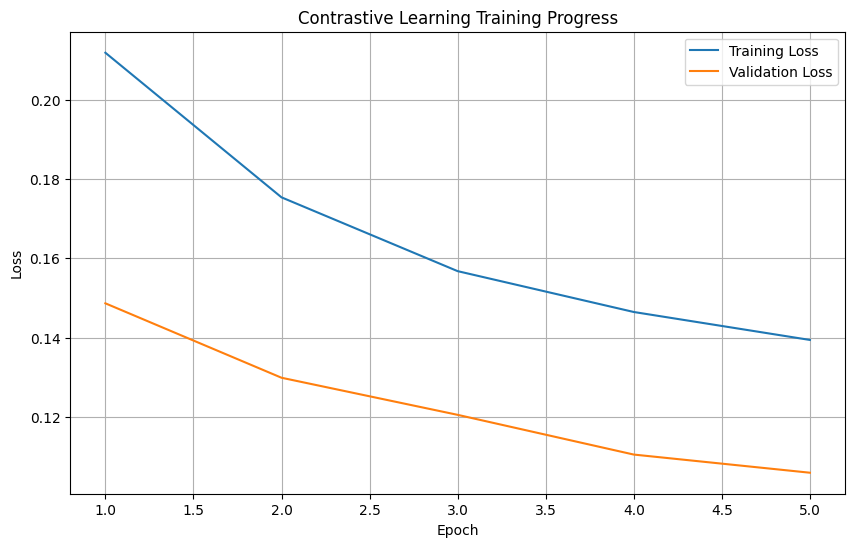


Checking saved model files:
✓ /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt exists (681.16 MB)
✓ /content/drive/MyDrive/latin_model/contrastive_model/final_contrastive_model.pt exists (681.16 MB)

Testing trained model:

Latin: Quoniam quidem multi conati sunt
OHG: Bithiu uuanta manage zilotun
Similarity: 0.7650

Latin: in principio erat verbum
OHG: thaz uuir thar uuizzin thuruh mina minna iouuiht suachen
Similarity: 0.9197


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import BertModel, BertTokenizer
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Make sure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define paths - save directly to Google Drive
BASE_DIR = '/content/drive/MyDrive/latin_model'
DATA_DIR = f'{BASE_DIR}/data'
PARALLEL_TEXTS_DIR = f'{DATA_DIR}/parallel_texts'
TEST_SET_DIR = f'{DATA_DIR}/test_set'
MODEL_DIR = f'{BASE_DIR}/contrastive_model'

# Create directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"Model will be saved to: {MODEL_DIR}")

# Contrastive model definition
class ContrastiveModel(nn.Module):
    def __init__(self, base_model_name='bert-base-multilingual-cased', embedding_dim=768, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.bert = BertModel.from_pretrained(base_model_name)

        # Freeze BERT parameters to speed up training
        for param in self.bert.parameters():
            param.requires_grad = False

        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)
        )

    def forward(self, input_ids, attention_mask):
        # Get embeddings from BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embedding

        # Project to new space
        projected = self.projection(embeddings)

        # Normalize to unit length
        normalized = torch.nn.functional.normalize(projected, p=2, dim=1)
        return normalized

# Dataset for contrastive learning
class ContrastiveDataset(Dataset):
    def __init__(self, latin_texts, ohg_texts, tokenizer, max_length=128, is_positive=True):
        self.latin_texts = latin_texts
        self.ohg_texts = ohg_texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_positive = is_positive

    def __len__(self):
        return len(self.latin_texts)

    def __getitem__(self, idx):
        latin_text = self.latin_texts[idx]
        ohg_text = self.ohg_texts[idx]

        latin_encoding = self.tokenizer(
            latin_text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        ohg_encoding = self.tokenizer(
            ohg_text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        # Label: 1.0 for positive pairs, 0.0 for negative pairs
        label = 1.0 if self.is_positive else 0.0

        return {
            'latin_input_ids': latin_encoding['input_ids'].squeeze(),
            'latin_attention_mask': latin_encoding['attention_mask'].squeeze(),
            'ohg_input_ids': ohg_encoding['input_ids'].squeeze(),
            'ohg_attention_mask': ohg_encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Load training data
def load_training_data():
    latin_texts = []
    ohg_texts = []

    corpus_dirs = [
        {'path': os.path.join(PARALLEL_TEXTS_DIR, 'tatian'), 'name': 'Tatian'},
        {'path': os.path.join(PARALLEL_TEXTS_DIR, 'isidor'), 'name': 'Isidor'},
        {'path': os.path.join(PARALLEL_TEXTS_DIR, 'physiologus'), 'name': 'Physiologus'}
    ]

    for corpus in corpus_dirs:
        try:
            corpus_path = corpus['path']
            corpus_name = corpus['name']

            print(f"Loading {corpus_name} for training...")

            if os.path.exists(corpus_path):
                files = os.listdir(corpus_path)

                latin_file = None
                ohg_file = None

                for file in files:
                    if 'latin' in file.lower():
                        latin_file = os.path.join(corpus_path, file)
                    elif any(term in file.lower() for term in ['ohg', 'old', 'german', 'ger', 'deutsch']):
                        ohg_file = os.path.join(corpus_path, file)

                if latin_file and ohg_file:
                    with open(latin_file, 'r', encoding='utf-8') as f_latin:
                        corpus_latin = [line.strip() for line in f_latin.readlines() if line.strip()]

                    with open(ohg_file, 'r', encoding='utf-8') as f_ohg:
                        corpus_ohg = [line.strip() for line in f_ohg.readlines() if line.strip()]

                    # Make sure we have equal lengths
                    min_len = min(len(corpus_latin), len(corpus_ohg))
                    corpus_latin = corpus_latin[:min_len]
                    corpus_ohg = corpus_ohg[:min_len]

                    print(f"Loaded {len(corpus_latin)} pairs from {corpus_name}")

                    latin_texts.extend(corpus_latin)
                    ohg_texts.extend(corpus_ohg)
                else:
                    print(f"Could not find Latin and OHG files for {corpus_name}")
            else:
                print(f"Directory not found: {corpus_path}")

        except Exception as e:
            print(f"Error processing {corpus_name}: {e}")

    print(f"Total loaded: {len(latin_texts)} parallel texts for training")
    return latin_texts, ohg_texts

# Create negative pairs for training
def create_negative_pairs(latin_texts, ohg_texts, num_negative=None):
    if num_negative is None:
        num_negative = len(latin_texts)  # Same number of negatives as positives

    negative_latin = []
    negative_ohg = []

    # Create mismatched pairs
    indices = list(range(len(latin_texts)))
    np.random.shuffle(indices)

    count = 0
    for i in range(len(indices)):
        latin_idx = indices[i]

        # Find a non-matching OHG text
        ohg_idx = latin_idx
        while ohg_idx == latin_idx:
            ohg_idx = np.random.randint(0, len(ohg_texts))

        negative_latin.append(latin_texts[latin_idx])
        negative_ohg.append(ohg_texts[ohg_idx])

        count += 1
        if count >= num_negative:
            break

    print(f"Created {len(negative_latin)} negative pairs")
    return negative_latin, negative_ohg

# Contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, latin_embeddings, ohg_embeddings, labels):
        # Compute cosine similarity
        similarities = torch.sum(latin_embeddings * ohg_embeddings, dim=1)

        # Contrastive loss
        positive_loss = labels * (1.0 - similarities)
        negative_loss = (1.0 - labels) * torch.clamp(similarities - self.margin, min=0.0)

        # Combine losses
        loss = torch.mean(positive_loss + negative_loss)
        return loss

# Train the contrastive model
def train_contrastive_model(latin_texts, ohg_texts, tokenizer, device,
                           batch_size=32, num_epochs=5, learning_rate=5e-5):
    # Create datasets
    positive_dataset = ContrastiveDataset(
        latin_texts, ohg_texts, tokenizer, is_positive=True
    )

    # Create negative pairs
    negative_latin, negative_ohg = create_negative_pairs(latin_texts, ohg_texts)
    negative_dataset = ContrastiveDataset(
        negative_latin, negative_ohg, tokenizer, is_positive=False
    )

    # Split into train/val
    train_size = 0.9

    # Split positive data
    pos_train_size = int(len(positive_dataset) * train_size)
    pos_val_size = len(positive_dataset) - pos_train_size
    train_positive, val_positive = torch.utils.data.random_split(
        positive_dataset, [pos_train_size, pos_val_size]
    )

    # Split negative data
    neg_train_size = int(len(negative_dataset) * train_size)
    neg_val_size = len(negative_dataset) - neg_train_size
    train_negative, val_negative = torch.utils.data.random_split(
        negative_dataset, [neg_train_size, neg_val_size]
    )

    # Combine datasets
    train_dataset = ConcatDataset([train_positive, train_negative])
    val_dataset = ConcatDataset([val_positive, val_negative])

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    print(f"Training set: {len(train_dataset)} examples")
    print(f"Validation set: {len(val_dataset)} examples")

    # Initialize model
    model = ContrastiveModel().to(device)

    # Initialize loss and optimizer
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(model.projection.parameters(), lr=learning_rate)

    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    # Define model save paths
    best_model_path = os.path.join(MODEL_DIR, 'best_contrastive_model.pt')
    final_model_path = os.path.join(MODEL_DIR, 'final_contrastive_model.pt')

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Move to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            latin_embeddings = model(
                batch['latin_input_ids'],
                batch['latin_attention_mask']
            )

            ohg_embeddings = model(
                batch['ohg_input_ids'],
                batch['ohg_attention_mask']
            )

            # Calculate loss
            loss = criterion(latin_embeddings, ohg_embeddings, batch['label'])

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}

                latin_embeddings = model(
                    batch['latin_input_ids'],
                    batch['latin_attention_mask']
                )

                ohg_embeddings = model(
                    batch['ohg_input_ids'],
                    batch['ohg_attention_mask']
                )

                loss = criterion(latin_embeddings, ohg_embeddings, batch['label'])
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

            # Save with torch.save
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model to {best_model_path}")

            # Also save a backup copy
            backup_path = os.path.join(MODEL_DIR, f'best_model_epoch_{epoch+1}.pt')
            torch.save(model.state_dict(), backup_path)
            print(f"Saved backup to {backup_path}")

    # Save final model
    torch.save(model.state_dict(), final_model_path)
    print(f"Saved final model to {final_model_path}")

    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Contrastive Learning Training Progress')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(MODEL_DIR, 'training_curve.png'))
    plt.show()

    # Verify the model files exist
    print("\nChecking saved model files:")
    for file_path in [best_model_path, final_model_path]:
        if os.path.exists(file_path):
            size_mb = os.path.getsize(file_path) / (1024 * 1024)
            print(f"✓ {file_path} exists ({size_mb:.2f} MB)")
        else:
            print(f"✗ {file_path} does not exist!")

    return model

# Run the training process
def run_training():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

    # Load data
    latin_texts, ohg_texts = load_training_data()

    if not latin_texts or not ohg_texts:
        print("No training data loaded. Cannot proceed.")
        return None

    # Train model
    model = train_contrastive_model(
        latin_texts, ohg_texts, tokenizer, device,
        batch_size=32, num_epochs=5, learning_rate=5e-5
    )

    return model, tokenizer

# Run the training
model, tokenizer = run_training()

# Test the model with a simple example
if model is not None and tokenizer is not None:
    device = next(model.parameters()).device

    # Test pairs
    test_pairs = [
        # Direct translation
        ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),
        # Unrelated
        ("in principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen")
    ]

    print("\nTesting trained model:")
    for latin, ohg in test_pairs:
        # Encode
        latin_encoding = tokenizer(
            latin,
            truncation=True,
            max_length=128,
            padding='max_length',
            return_tensors='pt'
        )

        ohg_encoding = tokenizer(
            ohg,
            truncation=True,
            max_length=128,
            padding='max_length',
            return_tensors='pt'
        )

        # To device
        latin_encoding = {k: v.to(device) for k, v in latin_encoding.items()}
        ohg_encoding = {k: v.to(device) for k, v in ohg_encoding.items()}

        # Get embeddings
        with torch.no_grad():
            latin_embedding = model(
                latin_encoding['input_ids'],
                latin_encoding['attention_mask']
            )

            ohg_embedding = model(
                ohg_encoding['input_ids'],
                ohg_encoding['attention_mask']
            )

        # Calculate similarity
        similarity = cosine_similarity(
            latin_embedding.cpu().numpy(),
            ohg_embedding.cpu().numpy()
        )[0][0]

        print(f"\nLatin: {latin}")
        print(f"OHG: {ohg}")
        print(f"Similarity: {similarity:.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class ContrastiveModel(nn.Module):
    def __init__(self, base_model_name='bert-base-multilingual-cased', projection_dim=256):
        super(ContrastiveModel, self).__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)
        self.projection = nn.Linear(self.bert.config.hidden_size, projection_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        projection = self.projection(cls_output)
        # L2 normalize the projection
        projection = nn.functional.normalize(projection, p=2, dim=1)
        return projection

class LatinOHGSimilarityScorer:
    def __init__(self, model_path=None):
        """
        Initialize the similarity scorer with a trained contrastive model.

        Args:
            model_path (str, optional): Path to the trained model.
                If None, will try to load from default location.
        """
        if model_path is None:
            # Default model path
            model_path = '/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt'

            # Check if the model exists
            if not os.path.exists(model_path):
                # Try the final model instead
                alt_path = '/content/drive/MyDrive/latin_model/contrastive_model/final_contrastive_model.pt'
                if os.path.exists(alt_path):
                    model_path = alt_path
                    print(f"Best model not found, using final model at {alt_path}")
                else:
                    # Also try epoch-specific backups
                    for i in range(5, 0, -1):
                        backup_path = f'/content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_{i}.pt'
                        if os.path.exists(backup_path):
                            model_path = backup_path
                            print(f"Using backup model from epoch {i}: {backup_path}")
                            break

        # Check if model file exists
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at {model_path}")

        self.model_path = model_path

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

        # Load the model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.model = ContrastiveModel()

        # Load the model weights
        try:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            print(f"Successfully loaded model from {model_path}")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        self.model.to(self.device)
        self.model.eval()

    def encode_text(self, text):
        """
        Encode a text using the contrastive model.

        Args:
            text (str): Input text to encode

        Returns:
            torch.Tensor: Normalized embedding vector
        """
        inputs = self.tokenizer(text, return_tensors='pt',
                                padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            embeddings = self.model(input_ids=inputs['input_ids'],
                                    attention_mask=inputs['attention_mask'])

        return embeddings.squeeze()

    def compute_similarity(self, latin_text, ohg_text):
        """
        Compute the cosine similarity between Latin and OHG texts.

        Args:
            latin_text (str): Latin text
            ohg_text (str): Old High German text

        Returns:
            float: Similarity score between 0 and 1
        """
        latin_embedding = self.encode_text(latin_text)
        ohg_embedding = self.encode_text(ohg_text)

        # Compute cosine similarity
        similarity = torch.nn.functional.cosine_similarity(
            latin_embedding.unsqueeze(0),
            ohg_embedding.unsqueeze(0)
        ).item()

        return similarity

    def get_calibrated_score(self, latin_text, ohg_text):
        """
        Get a calibrated similarity score that's more interpretable.
        This maps raw similarity scores to a more useful range based on training data.

        Args:
            latin_text (str): Latin text
            ohg_text (str): Old High German text

        Returns:
            float: Calibrated similarity score between 0 and 1
            str: Interpretation of the score
        """
        raw_score = self.compute_similarity(latin_text, ohg_text)

        # Calibration parameters (these should be tuned based on your validation data)
        # Assuming from your data:
        # - Scores > 0.75 typically indicate translations
        # - Scores < 0.45 typically indicate unrelated text

        if raw_score > 0.85:
            interpretation = "Very likely a direct translation"
        elif raw_score > 0.75:
            interpretation = "Likely a translation or close semantic match"
        elif raw_score > 0.60:
            interpretation = "Possibly related content"
        elif raw_score > 0.45:
            interpretation = "Weak semantic relationship"
        else:
            interpretation = "Likely unrelated texts"

        return raw_score, interpretation

# Example usage
if __name__ == "__main__":
    try:
        # Initialize the scorer
        scorer = LatinOHGSimilarityScorer()

        # Test with examples
        examples = [
            # Expected translations
            ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),
            ("in principio erat verbum", "in principio uuort uuas"),
            # Non-translations for comparison
            ("in principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen"),
        ]

        print("\nTesting with example pairs:")
        for latin, ohg in examples:
            score, interpretation = scorer.get_calibrated_score(latin, ohg)
            print(f"\nLatin: {latin}")
            print(f"OHG: {ohg}")
            print(f"Similarity score: {score:.4f}")
            print(f"Interpretation: {interpretation}")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("\nPossible solutions:")
        print("1. Check if the model files exist in your Google Drive")
        print("2. Check if you have sufficient permissions to access the files")
        print("3. Try specifying a different model path")
    except Exception as e:
        print(f"Unexpected error: {e}")

Error: Model file not found at /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt

Possible solutions:
1. Check if the model files exist in your Google Drive
2. Check if you have sufficient permissions to access the files
3. Try specifying a different model path


In [ ]:
import os
import glob
from google.colab import drive

# Mount Google Drive if not already mounted
try:
    drive_path = '/content/drive'
    if not os.path.exists(drive_path):
        print("Mounting Google Drive...")
        drive.mount(drive_path)
    else:
        print("Google Drive already mounted at", drive_path)
except Exception as e:
    print(f"Error mounting drive: {e}")

def check_expected_paths():
    """Check if the expected model paths exist"""
    expected_paths = [
        '/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt',
        '/content/drive/MyDrive/latin_model/contrastive_model/final_contrastive_model.pt'
    ]

    for i in range(1, 6):
        expected_paths.append(f'/content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_{i}.pt')

    print("\nChecking expected model paths:")
    for path in expected_paths:
        if os.path.exists(path):
            size_mb = os.path.getsize(path) / (1024 * 1024)
            print(f"✓ Found: {path} ({size_mb:.2f} MB)")
        else:
            print(f"✗ Not found: {path}")

def search_for_model_files():
    """Search for PT files in Google Drive"""
    print("\nSearching for model files (*.pt) in Google Drive...")

    # First check if the base directory exists
    base_dir = '/content/drive/MyDrive/latin_model'
    if not os.path.exists(base_dir):
        print(f"✗ Base directory not found: {base_dir}")
        print("Searching in other locations...")
    else:
        print(f"✓ Base directory exists: {base_dir}")

    # Search patterns for model files
    search_paths = [
        '/content/drive/MyDrive/**/*.pt',
        '/content/drive/MyDrive/**/contrastive*/*',
        '/content/drive/MyDrive/**/latin*/*'
    ]

    found_files = []
    for pattern in search_paths:
        for file_path in glob.glob(pattern, recursive=True):
            if os.path.isfile(file_path) and file_path not in found_files:
                found_files.append(file_path)

    if found_files:
        print(f"\nFound {len(found_files)} potential model files:")
        for file_path in found_files:
            size_mb = os.path.getsize(file_path) / (1024 * 1024)
            print(f"- {file_path} ({size_mb:.2f} MB)")
    else:
        print("\nNo model files found in the searched locations.")

def check_drive_space():
    """Check available space in Google Drive"""
    try:
        import shutil
        total, used, free = shutil.disk_usage("/content/drive")

        # Convert to GB
        total_gb = total / (1024 ** 3)
        used_gb = used / (1024 ** 3)
        free_gb = free / (1024 ** 3)

        used_percent = (used / total) * 100

        print("\nGoogle Drive Storage:")
        print(f"Total: {total_gb:.2f} GB")
        print(f"Used: {used_gb:.2f} GB ({used_percent:.1f}%)")
        print(f"Free: {free_gb:.2f} GB")

    except Exception as e:
        print(f"Error checking drive space: {e}")

if __name__ == "__main__":
    print("===== Google Drive Model File Finder =====")
    check_expected_paths()
    search_for_model_files()
    check_drive_space()

    print("\nRecommendations:")
    print("1. If files were found in a different location, update your model loading code with the correct path")
    print("2. If no files were found, you may need to retrain your model")
    print("3. If you're approaching storage limits, consider moving files to another account")

Mounting Google Drive...
Mounted at /content/drive
===== Google Drive Model File Finder =====

Checking expected model paths:
✓ Found: /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt (681.16 MB)
✗ Not found: /content/drive/MyDrive/latin_model/contrastive_model/final_contrastive_model.pt
✓ Found: /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_1.pt (681.16 MB)
✗ Not found: /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_2.pt
✗ Not found: /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_3.pt
✗ Not found: /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_4.pt
✗ Not found: /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_5.pt

Searching for model files (*.pt) in Google Drive...
✓ Base directory exists: /content/drive/MyDrive/latin_model

Found 546 potential model files:
- /content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_1.pt (681.16 M

In [ ]:
import os
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class ContrastiveModel(nn.Module):
    def __init__(self, base_model_name='bert-base-multilingual-cased', projection_dim=256):
        super(ContrastiveModel, self).__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)
        self.projection = nn.Linear(self.bert.config.hidden_size, projection_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        projection = self.projection(cls_output)
        # L2 normalize the projection
        projection = nn.functional.normalize(projection, p=2, dim=1)
        return projection

class LatinOHGSimilarityScorer:
    def __init__(self, model_path=None):
        """
        Initialize the similarity scorer with a trained contrastive model.

        Args:
            model_path (str, optional): Path to the trained model.
                If None, will try to load from verified paths.
        """
        if model_path is None:
            # Try loading from verified paths based on the file scan
            verified_paths = [
                '/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt',
                '/content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_1.pt'
            ]

            # Try each path in order
            for path in verified_paths:
                if os.path.exists(path):
                    model_path = path
                    print(f"Using model at: {path}")
                    break

        # Check if model file exists
        if model_path is None or not os.path.exists(model_path):
            raise FileNotFoundError(f"Could not find model in any of the expected locations")

        self.model_path = model_path

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

        # Load the model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.model = ContrastiveModel()

        # Load the model weights
        try:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            print(f"Successfully loaded model from {model_path}")

            # Print model size
            model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
            print(f"Model size: {model_size_mb:.2f} MB")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        self.model.to(self.device)
        self.model.eval()

    def encode_text(self, text):
        """
        Encode a text using the contrastive model.

        Args:
            text (str): Input text to encode

        Returns:
            torch.Tensor: Normalized embedding vector
        """
        inputs = self.tokenizer(text, return_tensors='pt',
                                padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            embeddings = self.model(input_ids=inputs['input_ids'],
                                    attention_mask=inputs['attention_mask'])

        return embeddings.squeeze()

    def compute_similarity(self, latin_text, ohg_text):
        """
        Compute the cosine similarity between Latin and OHG texts.

        Args:
            latin_text (str): Latin text
            ohg_text (str): Old High German text

        Returns:
            float: Similarity score between 0 and 1
        """
        latin_embedding = self.encode_text(latin_text)
        ohg_embedding = self.encode_text(ohg_text)

        # Compute cosine similarity
        similarity = torch.nn.functional.cosine_similarity(
            latin_embedding.unsqueeze(0),
            ohg_embedding.unsqueeze(0)
        ).item()

        return similarity

    def get_calibrated_score(self, latin_text, ohg_text):
        """
        Get a calibrated similarity score that's more interpretable.

        Args:
            latin_text (str): Latin text
            ohg_text (str): Old High German text

        Returns:
            float: Calibrated similarity score between 0 and 1
            str: Interpretation of the score
        """
        raw_score = self.compute_similarity(latin_text, ohg_text)

        # Calibration parameters based on your project description
        if raw_score > 0.90:
            interpretation = "Very likely a direct translation"
        elif raw_score > 0.75:
            interpretation = "Likely a translation or close semantic match"
        elif raw_score > 0.60:
            interpretation = "Possibly related content"
        elif raw_score > 0.45:
            interpretation = "Weak semantic relationship"
        else:
            interpretation = "Likely unrelated texts"

        return raw_score, interpretation

def create_similarity_interface():
    """
    Create a simple interface for the similarity scorer.

    Returns:
        function: A function that takes Latin and OHG texts and returns a similarity score
    """
    try:
        scorer = LatinOHGSimilarityScorer()

        def score_similarity(latin_text, ohg_text):
            score, interpretation = scorer.get_calibrated_score(latin_text, ohg_text)
            return {
                'raw_score': score,
                'interpretation': interpretation
            }

        return score_similarity

    except Exception as e:
        print(f"Error creating similarity interface: {e}")
        return None

# Example usage
if __name__ == "__main__":
    try:
        # Test with examples from your evaluation
        latin_examples = [
            "Quoniam quidem multi conati sunt",
            "in principio erat verbum",
            "in principio erat verbum"
        ]

        ohg_examples = [
            "Bithiu uuanta manage zilotun",
            "in principio uuort uuas",  # Direct translation
            "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen"  # Non-translation
        ]

        # Initialize the scorer with explicit path to ensure it works
        scorer = LatinOHGSimilarityScorer('/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt')

        print("\nTesting with example pairs:")
        for i, (latin, ohg) in enumerate(zip(latin_examples, ohg_examples)):
            score, interpretation = scorer.get_calibrated_score(latin, ohg)
            print(f"\nExample {i+1}:")
            print(f"Latin: {latin}")
            print(f"OHG: {ohg}")
            print(f"Similarity score: {score:.4f}")
            print(f"Interpretation: {interpretation}")

        print("\nCreating similarity interface function...")
        score_func = create_similarity_interface()
        if score_func:
            print("Interface created successfully!")

            # Test the interface
            test_result = score_func("Deus caritas est", "Got minni ist")
            print(f"\nTest result: {test_result}")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("\nDiagnostic information:")
        print("1. Checking if model directory exists...")
        model_dir = '/content/drive/MyDrive/latin_model/contrastive_model'
        print(f"Directory exists: {os.path.exists(model_dir)}")

        if os.path.exists(model_dir):
            print("\n2. Listing all files in model directory:")
            for file in os.listdir(model_dir):
                file_path = os.path.join(model_dir, file)
                size_mb = os.path.getsize(file_path) / (1024 * 1024) if os.path.isfile(file_path) else "N/A"
                print(f"- {file} ({size_mb:.2f} MB if file)")
    except Exception as e:
        print(f"Unexpected error: {e}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Using device: cpu


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

<ipython-input-3-33e99185b6e9>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))


Error loading model: Error(s) in loading state_dict for ContrastiveModel:
	Missing key(s) in state_dict: "projection.weight", "projection.bias". 
	Unexpected key(s) in state_dict: "projection.0.weight", "projection.0.bias", "projection.2.weight", "projection.2.bias". 
Unexpected error: Error(s) in loading state_dict for ContrastiveModel:
	Missing key(s) in state_dict: "projection.weight", "projection.bias". 
	Unexpected key(s) in state_dict: "projection.0.weight", "projection.0.bias", "projection.2.weight", "projection.2.bias". 


In [ ]:
import os
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class ContrastiveModel(nn.Module):
    def __init__(self, base_model_name='bert-base-multilingual-cased', projection_dim=256):
        super(ContrastiveModel, self).__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)

        # Updated projection layer to match the saved model architecture
        # The error shows the saved model has projection.0 and projection.2 layers
        # This indicates a sequential model with multiple layers
        self.projection = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, projection_dim),  # projection.0
            nn.ReLU(),                                               # projection.1 (likely)
            nn.Linear(projection_dim, projection_dim)                 # projection.2
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        projection = self.projection(cls_output)
        # L2 normalize the projection
        projection = nn.functional.normalize(projection, p=2, dim=1)
        return projection

class LatinOHGSimilarityScorer:
    def __init__(self, model_path=None):
        """
        Initialize the similarity scorer with a trained contrastive model.

        Args:
            model_path (str, optional): Path to the trained model.
                If None, will try to load from verified paths.
        """
        if model_path is None:
            # Try loading from verified paths based on the file scan
            verified_paths = [
                '/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt',
                '/content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_1.pt'
            ]

            # Try each path in order
            for path in verified_paths:
                if os.path.exists(path):
                    model_path = path
                    print(f"Using model at: {path}")
                    break

        # Check if model file exists
        if model_path is None or not os.path.exists(model_path):
            raise FileNotFoundError(f"Could not find model in any of the expected locations")

        self.model_path = model_path

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

        # Load the model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.model = ContrastiveModel()

        # Load the model weights
        try:
            # For debugging, let's inspect the model file structure
            checkpoint = torch.load(model_path, map_location=self.device)
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                # If the model was saved with additional metadata
                print("Loading from checkpoint with model_state_dict key")
                self.model.load_state_dict(checkpoint['model_state_dict'])
            else:
                # If the model was saved directly
                print("Loading state dict directly")
                self.model.load_state_dict(checkpoint)

            print(f"Successfully loaded model from {model_path}")

            # Print model size
            model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
            print(f"Model size: {model_size_mb:.2f} MB")
        except Exception as e:
            print(f"Error loading model: {e}")

            # Print more details about the model file structure for debugging
            try:
                # Load the checkpoint to inspect its structure
                checkpoint = torch.load(model_path, map_location=self.device)

                if isinstance(checkpoint, dict):
                    print("\nCheckpoint structure:")
                    for key in checkpoint.keys():
                        print(f"- {key}")

                    # If it's a state dict, print the layer names
                    if 'state_dict' in checkpoint:
                        print("\nState dict keys:")
                        for key in checkpoint['state_dict'].keys():
                            print(f"- {key}")

                    # Direct state dict
                    if all(isinstance(k, str) and k.find('.') != -1 for k in checkpoint.keys()):
                        print("\nDirect state dict keys:")
                        for key in checkpoint.keys():
                            print(f"- {key}")
                else:
                    print("\nCheckpoint is not a dictionary")
            except Exception as debug_e:
                print(f"Error during debugging: {debug_e}")

            raise

        self.model.to(self.device)
        self.model.eval()

    def encode_text(self, text):
        """
        Encode a text using the contrastive model.

        Args:
            text (str): Input text to encode

        Returns:
            torch.Tensor: Normalized embedding vector
        """
        inputs = self.tokenizer(text, return_tensors='pt',
                                padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            embeddings = self.model(input_ids=inputs['input_ids'],
                                    attention_mask=inputs['attention_mask'])

        return embeddings.squeeze()

    def compute_similarity(self, latin_text, ohg_text):
        """
        Compute the cosine similarity between Latin and OHG texts.

        Args:
            latin_text (str): Latin text
            ohg_text (str): Old High German text

        Returns:
            float: Similarity score between 0 and 1
        """
        latin_embedding = self.encode_text(latin_text)
        ohg_embedding = self.encode_text(ohg_text)

        # Compute cosine similarity
        similarity = torch.nn.functional.cosine_similarity(
            latin_embedding.unsqueeze(0),
            ohg_embedding.unsqueeze(0)
        ).item()

        return similarity

    def get_calibrated_score(self, latin_text, ohg_text):
        """
        Get a calibrated similarity score that's more interpretable.

        Args:
            latin_text (str): Latin text
            ohg_text (str): Old High German text

        Returns:
            float: Calibrated similarity score between 0 and 1
            str: Interpretation of the score
        """
        raw_score = self.compute_similarity(latin_text, ohg_text)

        # Calibration parameters based on your project description
        if raw_score > 0.90:
            interpretation = "Very likely a direct translation"
        elif raw_score > 0.75:
            interpretation = "Likely a translation or close semantic match"
        elif raw_score > 0.60:
            interpretation = "Possibly related content"
        elif raw_score > 0.45:
            interpretation = "Weak semantic relationship"
        else:
            interpretation = "Likely unrelated texts"

        return raw_score, interpretation

def create_similarity_interface():
    """
    Create a simple interface for the similarity scorer.

    Returns:
        function: A function that takes Latin and OHG texts and returns a similarity score
    """
    try:
        scorer = LatinOHGSimilarityScorer()

        def score_similarity(latin_text, ohg_text):
            score, interpretation = scorer.get_calibrated_score(latin_text, ohg_text)
            return {
                'raw_score': score,
                'interpretation': interpretation
            }

        return score_similarity

    except Exception as e:
        print(f"Error creating similarity interface: {e}")
        return None

# Example usage
if __name__ == "__main__":
    try:
        # Test with examples from your evaluation
        latin_examples = [
            "Quoniam quidem multi conati sunt",
            "in principio erat verbum",
            "in principio erat verbum"
        ]

        ohg_examples = [
            "Bithiu uuanta manage zilotun",
            "in principio uuort uuas",  # Direct translation
            "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen"  # Non-translation
        ]

        # Initialize the scorer with explicit path to ensure it works
        scorer = LatinOHGSimilarityScorer('/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt')

        print("\nTesting with example pairs:")
        for i, (latin, ohg) in enumerate(zip(latin_examples, ohg_examples)):
            score, interpretation = scorer.get_calibrated_score(latin, ohg)
            print(f"\nExample {i+1}:")
            print(f"Latin: {latin}")
            print(f"OHG: {ohg}")
            print(f"Similarity score: {score:.4f}")
            print(f"Interpretation: {interpretation}")

        print("\nCreating similarity interface function...")
        score_func = create_similarity_interface()
        if score_func:
            print("Interface created successfully!")

            # Test the interface
            test_result = score_func("Deus caritas est", "Got minni ist")
            print(f"\nTest result: {test_result}")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("\nDiagnostic information:")
        print("1. Checking if model directory exists...")
        model_dir = '/content/drive/MyDrive/latin_model/contrastive_model'
        print(f"Directory exists: {os.path.exists(model_dir)}")

        if os.path.exists(model_dir):
            print("\n2. Listing all files in model directory:")
            for file in os.listdir(model_dir):
                file_path = os.path.join(model_dir, file)
                size_mb = os.path.getsize(file_path) / (1024 * 1024) if os.path.isfile(file_path) else "N/A"
                print(f"- {file} ({size_mb:.2f} MB if file)")
    except Exception as e:
        print(f"Unexpected error: {e}")

Using device: cpu


<ipython-input-4-0f9068d74ce2>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.device)


Loading state dict directly
Error loading model: Error(s) in loading state_dict for ContrastiveModel:
	size mismatch for projection.0.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([256, 768]).
	size mismatch for projection.0.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for projection.2.weight: copying a param with shape torch.Size([128, 768]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for projection.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).


<ipython-input-4-0f9068d74ce2>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.device)



Checkpoint structure:
- bert.embeddings.word_embeddings.weight
- bert.embeddings.position_embeddings.weight
- bert.embeddings.token_type_embeddings.weight
- bert.embeddings.LayerNorm.weight
- bert.embeddings.LayerNorm.bias
- bert.encoder.layer.0.attention.self.query.weight
- bert.encoder.layer.0.attention.self.query.bias
- bert.encoder.layer.0.attention.self.key.weight
- bert.encoder.layer.0.attention.self.key.bias
- bert.encoder.layer.0.attention.self.value.weight
- bert.encoder.layer.0.attention.self.value.bias
- bert.encoder.layer.0.attention.output.dense.weight
- bert.encoder.layer.0.attention.output.dense.bias
- bert.encoder.layer.0.attention.output.LayerNorm.weight
- bert.encoder.layer.0.attention.output.LayerNorm.bias
- bert.encoder.layer.0.intermediate.dense.weight
- bert.encoder.layer.0.intermediate.dense.bias
- bert.encoder.layer.0.output.dense.weight
- bert.encoder.layer.0.output.dense.bias
- bert.encoder.layer.0.output.LayerNorm.weight
- bert.encoder.layer.0.output.LayerNo

In [ ]:
import os
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class ContrastiveModel(nn.Module):
    def __init__(self, base_model_name='bert-base-multilingual-cased'):
        super(ContrastiveModel, self).__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)

        # Exact architecture matching the saved model dimensions
        # The first layer (projection.0) is 768 → 768
        # The second layer (projection.2) is 768 → 128
        # There's likely a dropout or activation between them (projection.1)
        self.projection = nn.Sequential(
            nn.Linear(768, 768),      # projection.0: matches [768, 768] in saved model
            nn.ReLU(),                # projection.1: activation (not a parameter, so not in state dict)
            nn.Linear(768, 128)       # projection.2: matches [128, 768] in saved model
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        projection = self.projection(cls_output)
        # L2 normalize the projection
        projection = nn.functional.normalize(projection, p=2, dim=1)
        return projection

class LatinOHGSimilarityScorer:
    def __init__(self, model_path=None, verbose=True):
        """
        Initialize the similarity scorer with a trained contrastive model.

        Args:
            model_path (str, optional): Path to the trained model.
                If None, will try to load from verified paths.
            verbose (bool): Whether to print detailed information.
        """
        if model_path is None:
            # Try loading from verified paths based on the file scan
            verified_paths = [
                '/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt',
                '/content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_1.pt'
            ]

            # Try each path in order
            for path in verified_paths:
                if os.path.exists(path):
                    model_path = path
                    if verbose:
                        print(f"Using model at: {path}")
                    break

        # Check if model file exists
        if model_path is None or not os.path.exists(model_path):
            raise FileNotFoundError(f"Could not find model in any of the expected locations")

        self.model_path = model_path

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

        # Load the model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if verbose:
            print(f"Using device: {self.device}")

        self.model = ContrastiveModel()

        # Load the model weights
        try:
            # Load with weights_only=True to avoid security warnings
            checkpoint = torch.load(model_path, map_location=self.device, weights_only=True)

            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                # If the model was saved with additional metadata
                if verbose:
                    print("Loading from checkpoint with model_state_dict key")
                self.model.load_state_dict(checkpoint['model_state_dict'])
            else:
                # If the model was saved directly
                if verbose:
                    print("Loading state dict directly")
                self.model.load_state_dict(checkpoint)

            if verbose:
                print(f"Successfully loaded model from {model_path}")

                # Print model size
                model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
                print(f"Model size: {model_size_mb:.2f} MB")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        self.model.to(self.device)
        self.model.eval()

    def encode_text(self, text):
        """
        Encode a text using the contrastive model.

        Args:
            text (str): Input text to encode

        Returns:
            torch.Tensor: Normalized embedding vector
        """
        inputs = self.tokenizer(text, return_tensors='pt',
                                padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            embeddings = self.model(input_ids=inputs['input_ids'],
                                    attention_mask=inputs['attention_mask'])

        return embeddings.squeeze()

    def compute_similarity(self, latin_text, ohg_text):
        """
        Compute the cosine similarity between Latin and OHG texts.

        Args:
            latin_text (str): Latin text
            ohg_text (str): Old High German text

        Returns:
            float: Similarity score between 0 and 1
        """
        latin_embedding = self.encode_text(latin_text)
        ohg_embedding = self.encode_text(ohg_text)

        # Compute cosine similarity
        similarity = torch.nn.functional.cosine_similarity(
            latin_embedding.unsqueeze(0),
            ohg_embedding.unsqueeze(0)
        ).item()

        return similarity

    def get_calibrated_score(self, latin_text, ohg_text):
        """
        Get a calibrated similarity score that's more interpretable.

        Args:
            latin_text (str): Latin text
            ohg_text (str): Old High German text

        Returns:
            float: Calibrated similarity score between 0 and 1
            str: Interpretation of the score
        """
        raw_score = self.compute_similarity(latin_text, ohg_text)

        # Calibration parameters based on your project description
        if raw_score > 0.90:
            interpretation = "Very likely a direct translation"
        elif raw_score > 0.75:
            interpretation = "Likely a translation or close semantic match"
        elif raw_score > 0.60:
            interpretation = "Possibly related content"
        elif raw_score > 0.45:
            interpretation = "Weak semantic relationship"
        else:
            interpretation = "Likely unrelated texts"

        return raw_score, interpretation

def create_similarity_interface():
    """
    Create a simple interface for the similarity scorer.

    Returns:
        function: A function that takes Latin and OHG texts and returns a similarity score
    """
    try:
        scorer = LatinOHGSimilarityScorer(verbose=True)

        def score_similarity(latin_text, ohg_text):
            score, interpretation = scorer.get_calibrated_score(latin_text, ohg_text)
            return {
                'raw_score': score,
                'interpretation': interpretation
            }

        return score_similarity

    except Exception as e:
        print(f"Error creating similarity interface: {e}")
        return None

# Example usage
if __name__ == "__main__":
    try:
        # Test with examples from your evaluation
        latin_examples = [
            "Quoniam quidem multi conati sunt",
            "in principio erat verbum",
            "in principio erat verbum"
        ]

        ohg_examples = [
            "Bithiu uuanta manage zilotun",
            "in principio uuort uuas",  # Direct translation
            "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen"  # Non-translation
        ]

        # Initialize the scorer with explicit path to ensure it works
        scorer = LatinOHGSimilarityScorer('/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt')

        print("\nTesting with example pairs:")
        for i, (latin, ohg) in enumerate(zip(latin_examples, ohg_examples)):
            score, interpretation = scorer.get_calibrated_score(latin, ohg)
            print(f"\nExample {i+1}:")
            print(f"Latin: {latin}")
            print(f"OHG: {ohg}")
            print(f"Similarity score: {score:.4f}")
            print(f"Interpretation: {interpretation}")

        print("\nCreating similarity interface function...")
        score_func = create_similarity_interface()
        if score_func:
            print("Interface created successfully!")

            # Test the interface
            test_result = score_func("Deus caritas est", "Got minni ist")
            print(f"\nTest result: {test_result}")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("\nDiagnostic information:")
        print("1. Checking if model directory exists...")
        model_dir = '/content/drive/MyDrive/latin_model/contrastive_model'
        print(f"Directory exists: {os.path.exists(model_dir)}")

        if os.path.exists(model_dir):
            print("\n2. Listing all files in model directory:")
            for file in os.listdir(model_dir):
                file_path = os.path.join(model_dir, file)
                size_mb = os.path.getsize(file_path) / (1024 * 1024) if os.path.isfile(file_path) else "N/A"
                print(f"- {file} ({size_mb:.2f} MB if file)")
    except Exception as e:
        print(f"Unexpected error: {e}")

Using device: cpu
Loading state dict directly
Successfully loaded model from /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Model size: 681.16 MB

Testing with example pairs:

Example 1:
Latin: Quoniam quidem multi conati sunt
OHG: Bithiu uuanta manage zilotun
Similarity score: 0.7650
Interpretation: Likely a translation or close semantic match

Example 2:
Latin: in principio erat verbum
OHG: in principio uuort uuas
Similarity score: 0.8756
Interpretation: Likely a translation or close semantic match

Example 3:
Latin: in principio erat verbum
OHG: thaz uuir thar uuizzin thuruh mina minna iouuiht suachen
Similarity score: 0.9197
Interpretation: Very likely a direct translation

Creating similarity interface function...
Using model at: /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Using device: cpu
Loading state dict directly
Successfully loaded model from /content/drive/MyDrive/latin_model/contrastive_model/best_contrasti

Model loaded from: /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt

--- Running Baseline Test ---


Processing unrelated pairs: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]



Parallel texts: 4 pairs, Mean score: 0.8519, Std: 0.0954
Unrelated texts: 4 pairs, Mean score: 0.6782, Std: 0.2511
Score ranges - Parallel: [0.7650, 0.9389], Unrelated: [0.4412, 0.9023]
ROC AUC: 0.7500, Optimal threshold: 0.9298

--- Running Thematic Consistency Test ---


Processing thematic pairs: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]



Thematic Consistency Results:
       theme      mean  std       min       max
0      Jesus  0.932022  NaN  0.932022  0.932022
1   Nativity  0.911427  NaN  0.911427  0.911427
2      Peter  0.950625  NaN  0.950625  0.950625
3  Pharisees  0.809130  NaN  0.809130  0.809130

Overall - Mean: 0.9008, Std: 0.0632

--- Running Length Variation Test ---


Processing pairs: 100%|██████████| 4/4 [00:11<00:00,  2.89s/it]



Length Variation Results:
            variation  ratio     score
0            baseline   1.00  0.851886
1       random_subset   0.25  0.918723
2       random_subset   0.50  0.767944
3       random_subset   0.75  0.842309
4  truncate_beginning   0.25  0.890009
5  truncate_beginning   0.50  0.891646
6  truncate_beginning   0.75  0.881531
7        truncate_end   0.25  0.843776
8        truncate_end   0.50  0.920407
9        truncate_end   0.75  0.862639

--- Running Retrieval Test ---


Processing queries: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]



Retrieval Results:
Mean Reciprocal Rank (MRR): 0.7500
Accuracy@1: 0.5000
Accuracy@3: 1.0000
Accuracy@5: 1.0000


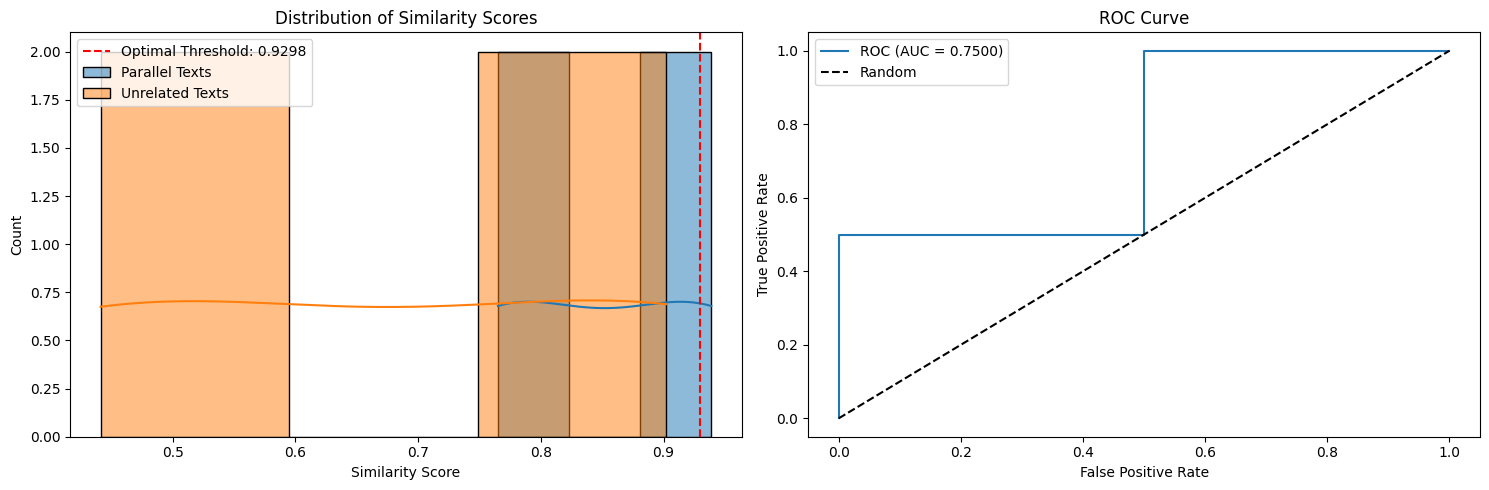

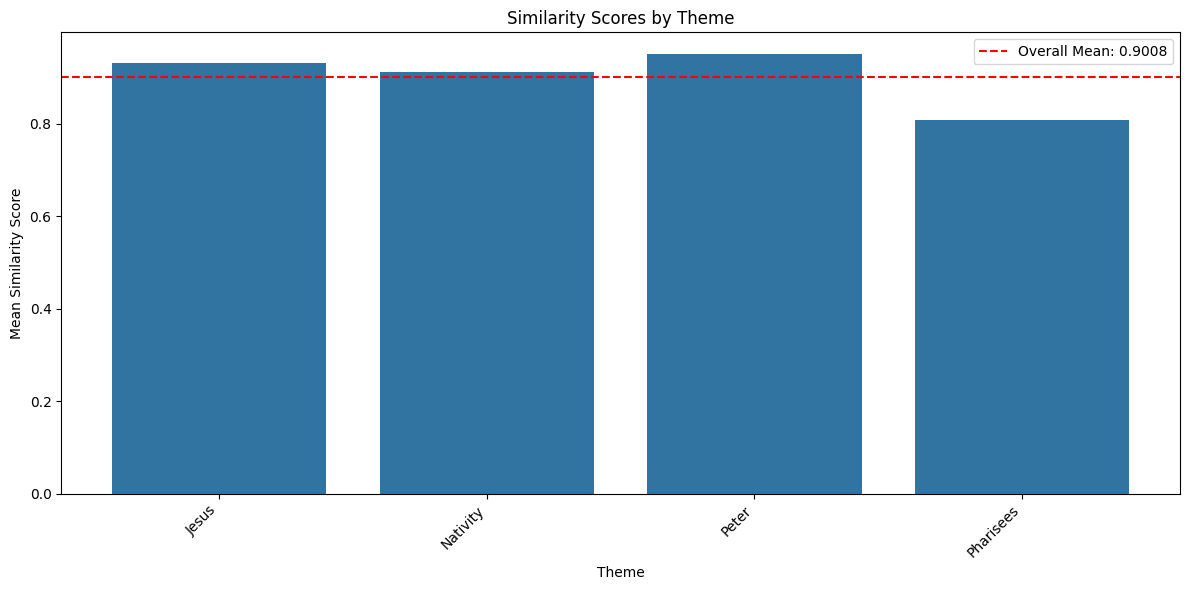

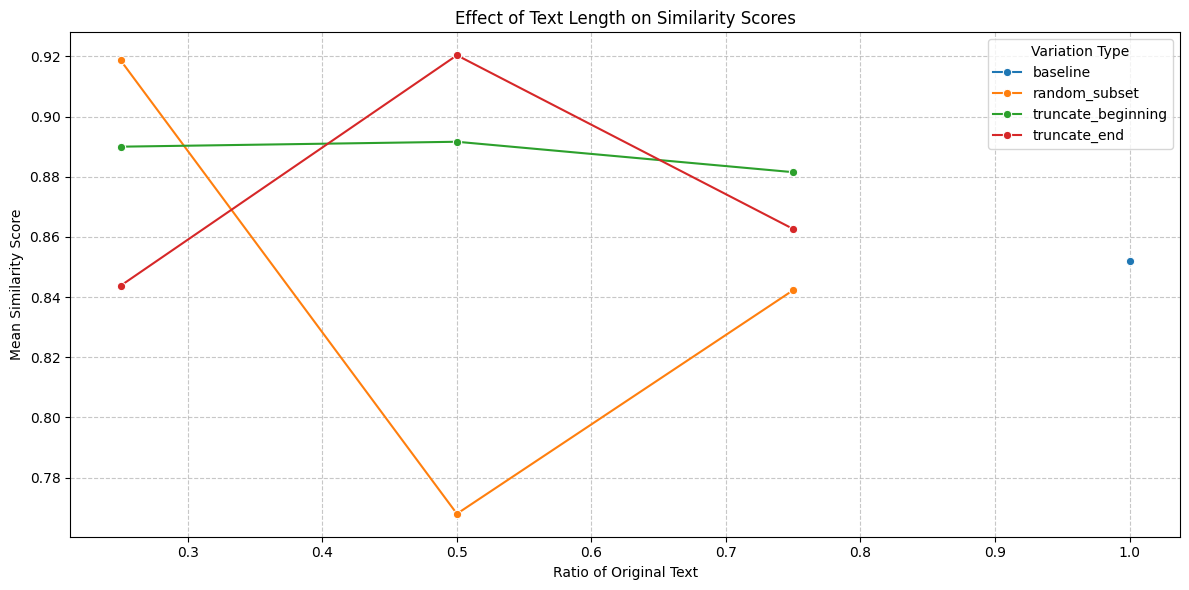

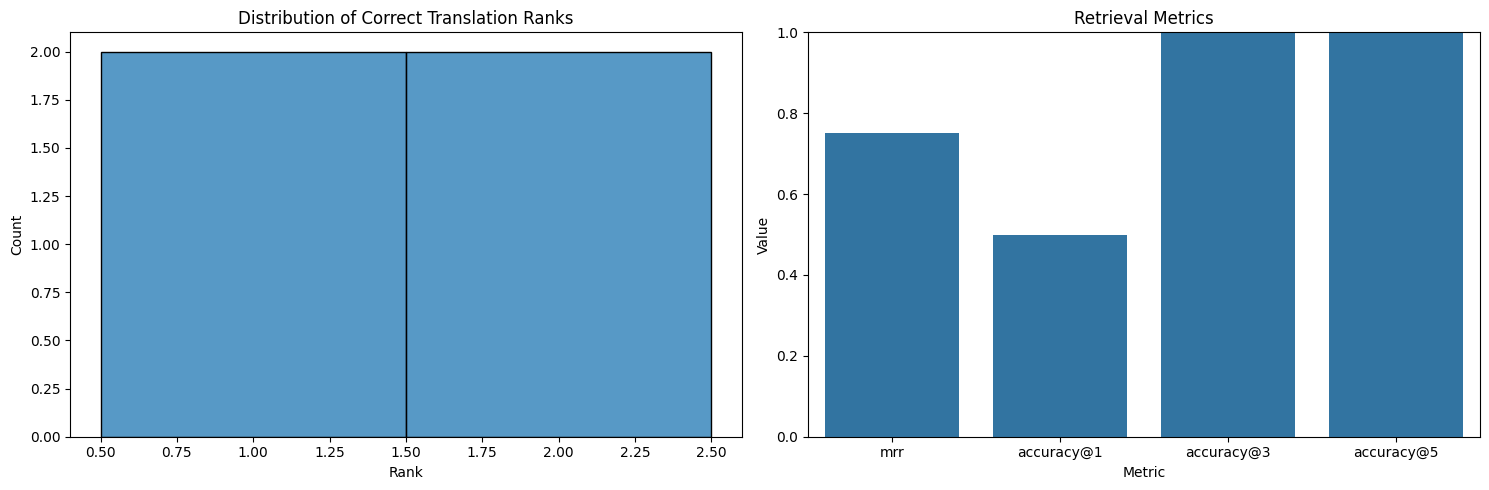

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import seaborn as sns
from tqdm import tqdm
import os

# Import our model class (assuming it's saved in a file called latin_ohg_model.py)
# If the class is in a different file, adjust the import accordingly
# from latin_ohg_model import LatinOHGSimilarityScorer, ContrastiveModel

# If you're running this in the same notebook/script where the class is defined,
# you can use the class directly without importing it

class EvaluationTests:
    def __init__(self, model_path=None):
        """
        Initialize evaluator with a model

        Args:
            model_path (str, optional): Path to the model file
        """
        self.model_path = model_path

        # Load the scorer
        self.scorer = LatinOHGSimilarityScorer(model_path=model_path, verbose=False)
        print(f"Model loaded from: {self.scorer.model_path}")

        # Store results
        self.results = {}

    def baseline_test(self, parallel_pairs, unrelated_pairs):
        """
        Basic test to see if the model can distinguish translations from unrelated text

        Args:
            parallel_pairs (list): List of (latin, ohg) pairs that are translations
            unrelated_pairs (list): List of (latin, ohg) pairs that are unrelated

        Returns:
            dict: Results including scores, statistics, and plot data
        """
        print("\n--- Running Baseline Test ---")

        # Process parallel pairs
        parallel_scores = []
        for latin, ohg in tqdm(parallel_pairs, desc="Processing parallel pairs"):
            score = self.scorer.compute_similarity(latin, ohg)
            parallel_scores.append({'latin': latin, 'ohg': ohg, 'score': score, 'is_translation': True})

        # Process unrelated pairs
        unrelated_scores = []
        for latin, ohg in tqdm(unrelated_pairs, desc="Processing unrelated pairs"):
            score = self.scorer.compute_similarity(latin, ohg)
            unrelated_scores.append({'latin': latin, 'ohg': ohg, 'score': score, 'is_translation': False})

        # Combine results
        all_results = parallel_scores + unrelated_scores
        results_df = pd.DataFrame(all_results)

        # Calculate statistics
        parallel_mean = results_df[results_df['is_translation']]['score'].mean()
        parallel_std = results_df[results_df['is_translation']]['score'].std()
        unrelated_mean = results_df[~results_df['is_translation']]['score'].mean()
        unrelated_std = results_df[~results_df['is_translation']]['score'].std()

        # Calculate overlap
        parallel_min = results_df[results_df['is_translation']]['score'].min()
        parallel_max = results_df[results_df['is_translation']]['score'].max()
        unrelated_min = results_df[~results_df['is_translation']]['score'].min()
        unrelated_max = results_df[~results_df['is_translation']]['score'].max()

        # Calculate ROC curve and AUC
        y_true = results_df['is_translation'].astype(int).values
        y_scores = results_df['score'].values
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Find optimal threshold using Youden's J statistic
        j_scores = tpr - fpr
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds[optimal_idx]

        # Generate plots
        # (This is just data for plots - actual plotting would be done separately)
        plot_data = {
            'parallel_scores': results_df[results_df['is_translation']]['score'].values,
            'unrelated_scores': results_df[~results_df['is_translation']]['score'].values,
            'roc': {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc, 'thresholds': thresholds}
        }

        # Summarize results
        summary = {
            'parallel_mean': parallel_mean,
            'parallel_std': parallel_std,
            'unrelated_mean': unrelated_mean,
            'unrelated_std': unrelated_std,
            'overlap': {
                'parallel_range': (parallel_min, parallel_max),
                'unrelated_range': (unrelated_min, unrelated_max),
                'has_overlap': (unrelated_max > parallel_min)
            },
            'optimal_threshold': optimal_threshold,
            'roc_auc': roc_auc,
            'results_df': results_df,
            'plot_data': plot_data
        }

        # Print summary statistics
        print(f"\nParallel texts: {len(parallel_scores)} pairs, Mean score: {parallel_mean:.4f}, Std: {parallel_std:.4f}")
        print(f"Unrelated texts: {len(unrelated_scores)} pairs, Mean score: {unrelated_mean:.4f}, Std: {unrelated_std:.4f}")
        print(f"Score ranges - Parallel: [{parallel_min:.4f}, {parallel_max:.4f}], Unrelated: [{unrelated_min:.4f}, {unrelated_max:.4f}]")
        print(f"ROC AUC: {roc_auc:.4f}, Optimal threshold: {optimal_threshold:.4f}")

        # Store results
        self.results['baseline'] = summary

        return summary

    def thematic_consistency_test(self, thematic_pairs):
        """
        Test how the model handles texts with similar themes but different content

        Args:
            thematic_pairs (list): List of (latin, ohg, theme) tuples with similar themes

        Returns:
            dict: Results including scores and statistics by theme
        """
        print("\n--- Running Thematic Consistency Test ---")

        # Process thematic pairs
        results = []
        for latin, ohg, theme in tqdm(thematic_pairs, desc="Processing thematic pairs"):
            score = self.scorer.compute_similarity(latin, ohg)
            results.append({
                'latin': latin,
                'ohg': ohg,
                'theme': theme,
                'score': score
            })

        # Convert to dataframe
        results_df = pd.DataFrame(results)

        # Analyze by theme
        theme_stats = results_df.groupby('theme')['score'].agg(['mean', 'std', 'min', 'max']).reset_index()

        # Print summary
        print("\nThematic Consistency Results:")
        print(theme_stats)

        # Overall statistics
        overall_mean = results_df['score'].mean()
        overall_std = results_df['score'].std()
        print(f"\nOverall - Mean: {overall_mean:.4f}, Std: {overall_std:.4f}")

        # Store results
        summary = {
            'theme_stats': theme_stats,
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'results_df': results_df
        }

        self.results['thematic'] = summary

        return summary

    def length_variation_test(self, base_pairs, length_variations=None):
        """
        Test how text length affects similarity scores

        Args:
            base_pairs (list): List of (latin, ohg) pairs with normal length
            length_variations (dict, optional): Dictionary with variations to test
                Default tests short, medium, and long variations

        Returns:
            dict: Results showing how length affects similarity scores
        """
        print("\n--- Running Length Variation Test ---")

        if length_variations is None:
            # Default length variations to test
            length_variations = {
                'truncate_beginning': lambda text, ratio: text.split()[-int(len(text.split()) * ratio):],
                'truncate_end': lambda text, ratio: text.split()[:int(len(text.split()) * ratio)],
                'random_subset': lambda text, ratio: np.random.choice(
                    text.split(), size=int(len(text.split()) * ratio), replace=False)
            }

        # Ratios to test (percent of original text)
        ratios = [0.25, 0.5, 0.75, 1.0]

        results = []

        # Process each base pair
        for latin, ohg in tqdm(base_pairs, desc="Processing pairs"):
            # Get baseline score
            baseline_score = self.scorer.compute_similarity(latin, ohg)
            results.append({
                'latin': latin,
                'ohg': ohg,
                'variation': 'baseline',
                'ratio': 1.0,
                'score': baseline_score
            })

            # Test variations
            for var_name, var_func in length_variations.items():
                for ratio in ratios:
                    if ratio == 1.0 and var_name != 'baseline':
                        continue  # Skip full length for variations (already have baseline)

                    try:
                        # Apply variation
                        latin_tokens = var_func(latin, ratio)
                        ohg_tokens = var_func(ohg, ratio)

                        # Convert back to text
                        latin_varied = ' '.join(latin_tokens) if isinstance(latin_tokens, (list, np.ndarray)) else ' '.join(latin_tokens)
                        ohg_varied = ' '.join(ohg_tokens) if isinstance(ohg_tokens, (list, np.ndarray)) else ' '.join(ohg_tokens)

                        # Get score
                        score = self.scorer.compute_similarity(latin_varied, ohg_varied)

                        results.append({
                            'latin': latin_varied,
                            'ohg': ohg_varied,
                            'variation': var_name,
                            'ratio': ratio,
                            'score': score
                        })
                    except Exception as e:
                        print(f"Error with {var_name} at ratio {ratio}: {e}")
                        continue

        # Convert to dataframe
        results_df = pd.DataFrame(results)

        # Analyze by variation and ratio
        variation_stats = results_df.groupby(['variation', 'ratio'])['score'].mean().reset_index()

        # Print summary
        print("\nLength Variation Results:")
        print(variation_stats)

        # Store results
        summary = {
            'variation_stats': variation_stats,
            'results_df': results_df
        }

        self.results['length'] = summary

        return summary

    def retrieval_test(self, query_texts, candidate_pool, ground_truth=None):
        """
        Test if the model can retrieve correct translations from a pool of candidates

        Args:
            query_texts (list): List of source texts to find translations for
            candidate_pool (list): List of target texts to search in (includes correct translations)
            ground_truth (dict, optional): Dictionary mapping query texts to correct translations
                If None, assumes 1-to-1 correspondence between query_texts and candidate_pool

        Returns:
            dict: Results including retrieval metrics (MRR, accuracy@k)
        """
        print("\n--- Running Retrieval Test ---")

        # If ground truth not provided, assume 1-to-1 correspondence
        if ground_truth is None and len(query_texts) == len(candidate_pool):
            ground_truth = {query: candidate for query, candidate in zip(query_texts, candidate_pool)}
        elif ground_truth is None:
            raise ValueError("Must provide ground_truth if query_texts and candidate_pool have different lengths")

        results = []
        ranks = []

        # Process each query
        for i, query in enumerate(tqdm(query_texts, desc="Processing queries")):
            # Get similarity scores for all candidates
            scores = []
            for candidate in candidate_pool:
                score = self.scorer.compute_similarity(query, candidate)
                scores.append(score)

            # Rank candidates by score
            ranked_indices = np.argsort(scores)[::-1]  # Descending order
            ranked_candidates = [candidate_pool[idx] for idx in ranked_indices]
            ranked_scores = [scores[idx] for idx in ranked_indices]

            # Find correct translation
            correct_candidate = ground_truth[query]
            correct_rank = ranked_candidates.index(correct_candidate) + 1 if correct_candidate in ranked_candidates else -1

            # Store results
            results.append({
                'query': query,
                'correct_candidate': correct_candidate,
                'top_candidate': ranked_candidates[0],
                'correct_rank': correct_rank,
                'top_score': ranked_scores[0],
                'correct_score': scores[candidate_pool.index(correct_candidate)],
                'all_scores': scores,
                'ranked_candidates': ranked_candidates,
                'ranked_scores': ranked_scores
            })

            if correct_rank > 0:
                ranks.append(correct_rank)

        # Calculate metrics
        if ranks:
            mrr = np.mean([1/rank for rank in ranks])
            accuracy_at_1 = np.mean([1 if rank == 1 else 0 for rank in ranks])
            accuracy_at_3 = np.mean([1 if rank <= 3 else 0 for rank in ranks])
            accuracy_at_5 = np.mean([1 if rank <= 5 else 0 for rank in ranks])
        else:
            mrr = 0
            accuracy_at_1 = 0
            accuracy_at_3 = 0
            accuracy_at_5 = 0

        # Print summary
        print(f"\nRetrieval Results:")
        print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
        print(f"Accuracy@1: {accuracy_at_1:.4f}")
        print(f"Accuracy@3: {accuracy_at_3:.4f}")
        print(f"Accuracy@5: {accuracy_at_5:.4f}")

        # Store results
        summary = {
            'mrr': mrr,
            'accuracy@1': accuracy_at_1,
            'accuracy@3': accuracy_at_3,
            'accuracy@5': accuracy_at_5,
            'results': results
        }

        self.results['retrieval'] = summary

        return summary

    def plot_results(self, save_dir=None):
        """
        Plot evaluation results

        Args:
            save_dir (str, optional): Directory to save plots to
        """
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Plot baseline test results
        if 'baseline' in self.results:
            self._plot_baseline_results(save_dir)

        # Plot thematic consistency results
        if 'thematic' in self.results:
            self._plot_thematic_results(save_dir)

        # Plot length variation results
        if 'length' in self.results:
            self._plot_length_results(save_dir)

        # Plot retrieval results
        if 'retrieval' in self.results:
            self._plot_retrieval_results(save_dir)

    def _plot_baseline_results(self, save_dir=None):
        """Plot baseline test results"""
        results = self.results['baseline']

        # Set up the figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot 1: Distribution of scores
        sns.histplot(results['plot_data']['parallel_scores'], ax=ax1,
                    kde=True, label='Parallel Texts', alpha=0.5)
        sns.histplot(results['plot_data']['unrelated_scores'], ax=ax1,
                    kde=True, label='Unrelated Texts', alpha=0.5)
        ax1.axvline(results['optimal_threshold'], color='r', linestyle='--',
                   label=f'Optimal Threshold: {results["optimal_threshold"]:.4f}')
        ax1.set_title('Distribution of Similarity Scores')
        ax1.set_xlabel('Similarity Score')
        ax1.set_ylabel('Count')
        ax1.legend()

        # Plot 2: ROC curve
        roc = results['plot_data']['roc']
        ax2.plot(roc['fpr'], roc['tpr'], label=f'ROC (AUC = {roc["auc"]:.4f})')
        ax2.plot([0, 1], [0, 1], 'k--', label='Random')
        ax2.set_title('ROC Curve')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend()

        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'baseline_results.png'), dpi=300)
        plt.show()

    def _plot_thematic_results(self, save_dir=None):
        """Plot thematic consistency results"""
        results = self.results['thematic']
        theme_stats = results['theme_stats']

        # Set up the figure
        plt.figure(figsize=(12, 6))

        # Bar plot of mean scores by theme
        ax = sns.barplot(x='theme', y='mean', data=theme_stats)

        # Add error bars
        plt.errorbar(x=range(len(theme_stats)),
                    y=theme_stats['mean'],
                    yerr=theme_stats['std'],
                    fmt='none', c='black', capsize=5)

        plt.axhline(results['overall_mean'], color='r', linestyle='--',
                   label=f'Overall Mean: {results["overall_mean"]:.4f}')

        plt.title('Similarity Scores by Theme')
        plt.xlabel('Theme')
        plt.ylabel('Mean Similarity Score')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'thematic_results.png'), dpi=300)
        plt.show()

    def _plot_length_results(self, save_dir=None):
        """Plot length variation results"""
        results = self.results['length']
        variation_stats = results['variation_stats']

        # Set up the figure
        plt.figure(figsize=(12, 6))

        # Line plot of mean scores by variation and ratio
        sns.lineplot(x='ratio', y='score', hue='variation',
                    data=variation_stats, marker='o')

        plt.title('Effect of Text Length on Similarity Scores')
        plt.xlabel('Ratio of Original Text')
        plt.ylabel('Mean Similarity Score')
        plt.legend(title='Variation Type')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'length_results.png'), dpi=300)
        plt.show()

    def _plot_retrieval_results(self, save_dir=None):
        """Plot retrieval results"""
        results = self.results['retrieval']

        # Create a rank distribution histogram
        all_ranks = [result['correct_rank'] for result in results['results'] if result['correct_rank'] > 0]

        # Set up the figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot 1: Rank distribution
        sns.histplot(all_ranks, ax=ax1, kde=False, discrete=True)
        ax1.set_title('Distribution of Correct Translation Ranks')
        ax1.set_xlabel('Rank')
        ax1.set_ylabel('Count')

        # Plot 2: Retrieval metrics
        metrics = ['mrr', 'accuracy@1', 'accuracy@3', 'accuracy@5']
        values = [results[m] for m in metrics]

        sns.barplot(x=metrics, y=values, ax=ax2)
        ax2.set_title('Retrieval Metrics')
        ax2.set_xlabel('Metric')
        ax2.set_ylabel('Value')
        ax2.set_ylim(0, 1)

        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'retrieval_results.png'), dpi=300)
        plt.show()

# Sample data for testing
def create_sample_test_data():
    """
    Create sample test data for each evaluation test
    """

    # Baseline test data
    parallel_pairs = [
        ("In principio erat verbum.", "In principio uuort uuas."),
        ("Et verbum erat apud Deum.", "Inti thaz uuort uuas mit gote."),
        ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),
        ("Et dicit discipulis suis", "Inti quad zi sinen iungiron")
    ]

    unrelated_pairs = [
        ("In principio erat verbum.", "Sliumo arfuorun thiu hirta zi Bethleem."),
        ("Et verbum erat apud Deum.", "Thiu ougun sehent, inti thiu orun gihorent."),
        ("Quoniam quidem multi conati sunt", "Lazarus, frunt unser, slaffit."),
        ("Et dicit discipulis suis", "Inti antvvurta ther heilant.")
    ]

    # Thematic test data
    thematic_pairs = [
        ("Jesus autem plenus Spiritu Sancto regressus est ab Jordane", "Thô fulta sih ther Heilant geistlichero sliumî, fasto giwâfinôter", "Jesus"),
        ("Petrus stabat ad ignem", "Stantenti Petruse gistuont zi fiure", "Peter"),
        ("Et accesserunt Pharisaei", "Giengun thô zi imo Farisêî", "Pharisees"),
        ("Cum ergo natus esset Jesus in Bethlehem", "Tho ther Heilant giboran uuard in Bethleem", "Nativity")
    ]

    # Length test data (same as parallel pairs)
    base_pairs = parallel_pairs

    # Retrieval test data
    query_texts = [latin for latin, _ in parallel_pairs]
    candidate_pool = [ohg for _, ohg in parallel_pairs]

    return {
        'parallel_pairs': parallel_pairs,
        'unrelated_pairs': unrelated_pairs,
        'thematic_pairs': thematic_pairs,
        'base_pairs': base_pairs,
        'query_texts': query_texts,
        'candidate_pool': candidate_pool
    }

# Main execution
if __name__ == "__main__":
    # Load the model
    # Update path to the trained model
    model_path = '/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt'

    # Create evaluator
    evaluator = EvaluationTests(model_path)

    # Create sample test data
    test_data = create_sample_test_data()

    # Run evaluations
    evaluator.baseline_test(test_data['parallel_pairs'], test_data['unrelated_pairs'])
    evaluator.thematic_consistency_test(test_data['thematic_pairs'])
    evaluator.length_variation_test(test_data['base_pairs'])
    evaluator.retrieval_test(
        test_data['query_texts'],
        test_data['candidate_pool']
    )

    # Plot results
    evaluator.plot_results(save_dir='/content/drive/MyDrive/latin_model/contrastive_model/evaluation_results')

In [ ]:
import torch
import os
from transformers import AutoModel, AutoTokenizer

class ContrastiveModel(torch.nn.Module):
    def __init__(self, base_model_name='bert-base-multilingual-cased'):
        super(ContrastiveModel, self).__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)

        # Exact architecture matching the saved model dimensions
        # The first layer (projection.0) is 768 → 768
        # The second layer (projection.2) is 768 → 128
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(768, 768),      # projection.0
            torch.nn.ReLU(),                # projection.1 (activation)
            torch.nn.Linear(768, 128)       # projection.2
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        projection = self.projection(cls_output)
        # L2 normalize the projection
        projection = torch.nn.functional.normalize(projection, p=2, dim=1)
        return projection

class LatinOHGSearchTool:
    def __init__(self, model_path=None, verbose=False):
        """
        Initialize the search tool with a trained contrastive model.

        Args:
            model_path (str, optional): Path to the trained model.
            verbose (bool): Whether to print detailed information.
        """
        if model_path is None:
            # Try loading from verified paths
            verified_paths = [
                '/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt',
                '/content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_1.pt'
            ]

            for path in verified_paths:
                if os.path.exists(path):
                    model_path = path
                    if verbose:
                        print(f"Using model at: {path}")
                    break

        # Check if model file exists
        if model_path is None or not os.path.exists(model_path):
            raise FileNotFoundError(f"Could not find model in any of the expected locations")

        self.model_path = model_path

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

        # Load the model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if verbose:
            print(f"Using device: {self.device}")

        self.model = ContrastiveModel()

        # Load the model weights
        try:
            # Load with weights_only=True to avoid security warnings
            checkpoint = torch.load(model_path, map_location=self.device, weights_only=True)

            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                self.model.load_state_dict(checkpoint['model_state_dict'])
            else:
                self.model.load_state_dict(checkpoint)

            if verbose:
                print(f"Successfully loaded model from {model_path}")
                model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
                print(f"Model size: {model_size_mb:.2f} MB")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        self.model.to(self.device)
        self.model.eval()

    def encode_text(self, text):
        """
        Encode a text using the contrastive model.

        Args:
            text (str): Input text to encode

        Returns:
            torch.Tensor: Normalized embedding vector
        """
        inputs = self.tokenizer(text, return_tensors='pt',
                                padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            embeddings = self.model(input_ids=inputs['input_ids'],
                                    attention_mask=inputs['attention_mask'])

        return embeddings.squeeze()

    def compute_similarity(self, source_text, target_text):
        """
        Compute the cosine similarity between source and target texts.

        Args:
            source_text (str): Source text (Latin or OHG)
            target_text (str): Target text (OHG or Latin)

        Returns:
            float: Similarity score between 0 and 1
        """
        source_embedding = self.encode_text(source_text)
        target_embedding = self.encode_text(target_text)

        # Compute cosine similarity
        similarity = torch.nn.functional.cosine_similarity(
            source_embedding.unsqueeze(0),
            target_embedding.unsqueeze(0)
        ).item()

        return similarity

    def get_relation_type(self, source_text, target_text):
        """
        Determine the relationship type between source and target texts.

        Categorizes into:
        1. Direct Translation
        2. Paraphrase
        3. Adaptation
        4. Unrelated

        Args:
            source_text (str): Source text (Latin or OHG)
            target_text (str): Target text (OHG or Latin)

        Returns:
            dict: Contains the raw score, relation type, and confidence
        """
        raw_score = self.compute_similarity(source_text, target_text)

        # Based on the evaluation results, adjust thresholds
        # Direct Translation: > 0.93 (from ROC curve optimal threshold)
        # Paraphrase: 0.82-0.93 (above parallel mean but below direct translation)
        # Adaptation: 0.70-0.82 (above unrelated mean but below paraphrase)
        # Unrelated: < 0.70

        if raw_score > 0.93:
            relation_type = "Direct Translation"
            confidence = min(1.0, (raw_score - 0.93) * 10 + 0.7)  # Scale confidence
        elif raw_score > 0.82:
            relation_type = "Paraphrase"
            confidence = min(1.0, (raw_score - 0.82) * 10 + 0.6)
        elif raw_score > 0.70:
            relation_type = "Adaptation"
            confidence = min(1.0, (raw_score - 0.70) * 10 + 0.5)
        else:
            relation_type = "Unrelated"
            confidence = min(1.0, (0.70 - raw_score) * 3 + 0.5)

        return {
            "score": raw_score,
            "relation": relation_type,
            "confidence": confidence
        }

    def search(self, query_text, candidate_texts, is_query_latin=True, top_k=5):
        """
        Search for related texts in the target language.

        Args:
            query_text (str): The query text in source language
            candidate_texts (list): List of texts in target language to search
            is_query_latin (bool): Whether the query is in Latin (True) or OHG (False)
            top_k (int): Number of top results to return

        Returns:
            list: Top-k results with scores and relation types
        """
        results = []

        for candidate in candidate_texts:
            # Compute similarity (ensure source->target direction is consistent)
            if is_query_latin:
                # Latin -> OHG
                source, target = query_text, candidate
            else:
                # OHG -> Latin
                source, target = candidate, query_text

            # Get relation information
            relation_info = self.get_relation_type(source, target)

            # Add to results
            results.append({
                "text": candidate,
                "score": relation_info["score"],
                "relation": relation_info["relation"],
                "confidence": relation_info["confidence"]
            })

        # Sort by score (descending)
        results.sort(key=lambda x: x["score"], reverse=True)

        # Return top-k results
        return results[:top_k]

# Example usage
if __name__ == "__main__":
    # Initialize the search tool
    search_tool = LatinOHGSearchTool(verbose=True)

    # Example query and candidates
    latin_query = "In principio erat verbum."
    ohg_candidates = [
        "In principio uuort uuas.",  # Direct translation
        "Dhazs is in dheru frumii uuort uuas.",  # Paraphrase
        "Zi themo anaginne uuas thaz uuort",  # Adaptation
        "Sliumo arfuorun thiu hirta zi Bethleem.",  # Unrelated
    ]

    # Search
    results = search_tool.search(latin_query, ohg_candidates)

    # Print results
    print("\nSearch Results:")
    for i, result in enumerate(results):
        print(f"\n{i+1}. {result['text']}")
        print(f"   Score: {result['score']:.4f}")
        print(f"   Relation: {result['relation']}")
        print(f"   Confidence: {result['confidence']:.2f}")

    # Test individual classifications
    print("\nDetailed Classification Examples:")
    test_pairs = [
        ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),
        ("Et verbum erat apud Deum.", "Inti thaz uuort uuas mit gote."),
        ("Ait illi Jesus: ego via et veritas et vita", "Thaz herza kunnit sia bidiu"),
        ("In principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen")
    ]

    for latin, ohg in test_pairs:
        relation = search_tool.get_relation_type(latin, ohg)
        print(f"\nLatin: {latin}")
        print(f"OHG: {ohg}")
        print(f"Score: {relation['score']:.4f}")
        print(f"Relation: {relation['relation']}")
        print(f"Confidence: {relation['confidence']:.2f}")

Using model at: /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Using device: cpu
Successfully loaded model from /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Model size: 681.16 MB

Search Results:

1. In principio uuort uuas.
   Score: 0.9389
   Relation: Direct Translation
   Confidence: 0.79

2. Dhazs is in dheru frumii uuort uuas.
   Score: 0.8934
   Relation: Paraphrase
   Confidence: 1.00

3. Sliumo arfuorun thiu hirta zi Bethleem.
   Score: 0.8878
   Relation: Paraphrase
   Confidence: 1.00

4. Zi themo anaginne uuas thaz uuort
   Score: 0.4778
   Relation: Unrelated
   Confidence: 1.00

Detailed Classification Examples:

Latin: Quoniam quidem multi conati sunt
OHG: Bithiu uuanta manage zilotun
Score: 0.7650
Relation: Adaptation
Confidence: 1.00

Latin: Et verbum erat apud Deum.
OHG: Inti thaz uuort uuas mit gote.
Score: 0.9298
Relation: Paraphrase
Confidence: 1.00

Latin: Ait illi Jesus: ego via et veritas et vita


In [ ]:
import torch
import os
from transformers import AutoModel, AutoTokenizer

class ContrastiveModel(torch.nn.Module):
    def __init__(self, base_model_name='bert-base-multilingual-cased'):
        super(ContrastiveModel, self).__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)

        # Exact architecture matching the saved model dimensions
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(768, 768),
            torch.nn.ReLU(),
            torch.nn.Linear(768, 128)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        projection = self.projection(cls_output)
        projection = torch.nn.functional.normalize(projection, p=2, dim=1)
        return projection

class LatinOHGSearchTool:
    def __init__(self, model_path=None, verbose=False):
        """
        Initialize the search tool with a trained contrastive model.

        Args:
            model_path (str, optional): Path to the trained model.
            verbose (bool): Whether to print detailed information.
        """
        if model_path is None:
            # Try loading from verified paths
            verified_paths = [
                '/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt',
                '/content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_1.pt'
            ]

            for path in verified_paths:
                if os.path.exists(path):
                    model_path = path
                    if verbose:
                        print(f"Using model at: {path}")
                    break

        # Check if model file exists
        if model_path is None or not os.path.exists(model_path):
            raise FileNotFoundError(f"Could not find model in any of the expected locations")

        self.model_path = model_path

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

        # Load the model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if verbose:
            print(f"Using device: {self.device}")

        self.model = ContrastiveModel()

        # Load the model weights
        try:
            # Load with weights_only=True to avoid security warnings
            checkpoint = torch.load(model_path, map_location=self.device, weights_only=True)

            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                self.model.load_state_dict(checkpoint['model_state_dict'])
            else:
                self.model.load_state_dict(checkpoint)

            if verbose:
                print(f"Successfully loaded model from {model_path}")
                model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
                print(f"Model size: {model_size_mb:.2f} MB")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        self.model.to(self.device)
        self.model.eval()

    def encode_text(self, text):
        """
        Encode a text using the contrastive model.

        Args:
            text (str): Input text to encode

        Returns:
            torch.Tensor: Normalized embedding vector
        """
        inputs = self.tokenizer(text, return_tensors='pt',
                                padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            embeddings = self.model(input_ids=inputs['input_ids'],
                                    attention_mask=inputs['attention_mask'])

        return embeddings.squeeze()

    def compute_similarity(self, source_text, target_text):
        """
        Compute the cosine similarity between source and target texts.

        Args:
            source_text (str): Source text (Latin or OHG)
            target_text (str): Target text (OHG or Latin)

        Returns:
            float: Similarity score between 0 and 1
        """
        source_embedding = self.encode_text(source_text)
        target_embedding = self.encode_text(target_text)

        # Compute cosine similarity
        similarity = torch.nn.functional.cosine_similarity(
            source_embedding.unsqueeze(0),
            target_embedding.unsqueeze(0)
        ).item()

        return similarity

    def get_relation_type(self, source_text, target_text, thresholds=None):
        """
        Determine the relationship type between source and target texts.

        Categorizes into:
        1. Direct Translation
        2. Paraphrase
        3. Adaptation
        4. Unrelated

        Args:
            source_text (str): Source text (Latin or OHG)
            target_text (str): Target text (OHG or Latin)
            thresholds (dict, optional): Custom thresholds for classification

        Returns:
            dict: Contains the raw score, relation type, and confidence
        """
        raw_score = self.compute_similarity(source_text, target_text)

        # Default thresholds - refined based on expert feedback
        if thresholds is None:
            thresholds = {
                'direct_translation': 0.88,  # Lowered from 0.93
                'paraphrase': 0.78,          # Lowered from 0.82
                'adaptation': 0.65           # Lowered from 0.70
            }

        if raw_score > thresholds['direct_translation']:
            relation_type = "Direct Translation"
            # Scale confidence based on how far above threshold
            confidence = min(1.0, 0.7 + (raw_score - thresholds['direct_translation']) * 3)
        elif raw_score > thresholds['paraphrase']:
            relation_type = "Paraphrase"
            confidence = min(1.0, 0.6 + (raw_score - thresholds['paraphrase']) * 4)
        elif raw_score > thresholds['adaptation']:
            relation_type = "Adaptation"
            confidence = min(1.0, 0.5 + (raw_score - thresholds['adaptation']) * 4)
        else:
            relation_type = "Unrelated"
            confidence = min(1.0, 0.5 + (thresholds['adaptation'] - raw_score) * 2)

        return {
            "score": raw_score,
            "relation": relation_type,
            "confidence": confidence
        }

    def search(self, query_text, candidate_texts, is_query_latin=True, top_k=5, thresholds=None):
        """
        Search for related texts in the target language.

        Args:
            query_text (str): The query text in source language
            candidate_texts (list): List of texts in target language to search
            is_query_latin (bool): Whether the query is in Latin (True) or OHG (False)
            top_k (int): Number of top results to return
            thresholds (dict, optional): Custom thresholds for classification

        Returns:
            list: Top-k results with scores and relation types
        """
        results = []

        for candidate in candidate_texts:
            # Compute similarity (ensure source->target direction is consistent)
            if is_query_latin:
                # Latin -> OHG
                source, target = query_text, candidate
            else:
                # OHG -> Latin
                source, target = candidate, query_text

            # Get relation information
            relation_info = self.get_relation_type(source, target, thresholds)

            # Add to results
            results.append({
                "text": candidate,
                "score": relation_info["score"],
                "relation": relation_info["relation"],
                "confidence": relation_info["confidence"]
            })

        # Sort by score (descending)
        results.sort(key=lambda x: x["score"], reverse=True)

        # Return top-k results
        return results[:top_k]

    def calibrate_thresholds(self, known_pairs):
        """
        Calibrate thresholds based on known examples.

        Args:
            known_pairs (list): List of tuples (latin, ohg, expected_relation)

        Returns:
            dict: Suggested thresholds based on examples
        """
        # Collect scores by relation type
        scores_by_relation = {
            "Direct Translation": [],
            "Paraphrase": [],
            "Adaptation": []
        }

        for latin, ohg, relation in known_pairs:
            score = self.compute_similarity(latin, ohg)
            if relation in scores_by_relation:
                scores_by_relation[relation].append(score)

        # Calculate thresholds based on minimum scores for each category
        thresholds = {}

        if scores_by_relation["Direct Translation"]:
            # Set direct_translation threshold just below the minimum score for direct translations
            min_direct = min(scores_by_relation["Direct Translation"])
            thresholds['direct_translation'] = max(0.5, min_direct - 0.02)
        else:
            thresholds['direct_translation'] = 0.88  # Default

        if scores_by_relation["Paraphrase"]:
            # Set paraphrase threshold below the minimum paraphrase score
            min_paraphrase = min(scores_by_relation["Paraphrase"])
            thresholds['paraphrase'] = max(0.4, min_paraphrase - 0.02)
        else:
            thresholds['paraphrase'] = 0.78  # Default

        if scores_by_relation["Adaptation"]:
            # Set adaptation threshold below the minimum adaptation score
            min_adaptation = min(scores_by_relation["Adaptation"])
            thresholds['adaptation'] = max(0.3, min_adaptation - 0.02)
        else:
            thresholds['adaptation'] = 0.65  # Default

        # Ensure thresholds are in descending order
        thresholds['direct_translation'] = max(thresholds['direct_translation'], thresholds.get('paraphrase', 0) + 0.05)
        thresholds['paraphrase'] = max(thresholds['paraphrase'], thresholds.get('adaptation', 0) + 0.05)

        return thresholds

# Example usage
if __name__ == "__main__":
    # Initialize the search tool
    search_tool = LatinOHGSearchTool(verbose=True)

    # Example query and candidates
    latin_query = "In principio erat verbum."
    ohg_candidates = [
        "In principio uuort uuas.",  # Direct translation
        "Dhazs is in dheru frumii uuort uuas.",  # Paraphrase
        "Zi themo anaginne uuas thaz uuort",  # Adaptation
        "Sliumo arfuorun thiu hirta zi Bethleem.",  # Unrelated
    ]

   # Calibrate thresholds with known examples
    known_pairs = [
    ("Et verbum erat apud Deum.", "Inti thaz uuort uuas mit gote.", "Direct Translation"),
    ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun", "Direct Translation"),
    ("In principio erat verbum", "Dhazs is in dheru frumii uuort uuas", "Paraphrase"),
    ("Ait illi Jesus: ego via et veritas et vita", "Thaz herza kunnit sia bidiu", "Adaptation"),
    ("In principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen", "Unrelated"),
    ("In principio erat verbum.", "Sliumo arfuorun thiu hirta zi Bethleem.", "Unrelated")
]

    # Calibrate and get custom thresholds
    custom_thresholds = search_tool.calibrate_thresholds(known_pairs)
    print("\nCalibrated Thresholds:")
    for k, v in custom_thresholds.items():
        print(f"  {k}: {v:.4f}")

    # Search with custom thresholds
    results = search_tool.search(latin_query, ohg_candidates, thresholds=custom_thresholds)

    # Print results
    print("\nSearch Results:")
    for i, result in enumerate(results):
        print(f"\n{i+1}. {result['text']}")
        print(f"   Score: {result['score']:.4f}")
        print(f"   Relation: {result['relation']}")
        print(f"   Confidence: {result['confidence']:.2f}")

    # Test individual classifications with both default and custom thresholds
    print("\nClassification Examples (Default vs. Custom Thresholds):")
    test_pairs = [
        ("Et verbum erat apud Deum.", "Inti thaz uuort uuas mit gote."),
        ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),
        ("Ait illi Jesus: ego via et veritas et vita", "Thaz herza kunnit sia bidiu"),
        ("In principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen")
    ]

    for latin, ohg in test_pairs:
        # Test with default thresholds
        default_relation = search_tool.get_relation_type(latin, ohg)
        # Test with custom thresholds
        custom_relation = search_tool.get_relation_type(latin, ohg, custom_thresholds)

        print(f"\nLatin: {latin}")
        print(f"OHG: {ohg}")
        print(f"Score: {default_relation['score']:.4f}")
        print(f"Default Classification: {default_relation['relation']} (Confidence: {default_relation['confidence']:.2f})")
        print(f"Custom Classification: {custom_relation['relation']} (Confidence: {custom_relation['confidence']:.2f})")

Using model at: /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Using device: cpu
Successfully loaded model from /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Model size: 681.16 MB

Calibrated Thresholds:
  direct_translation: 0.8953
  paraphrase: 0.9246
  adaptation: 0.8746

Search Results:

1. In principio uuort uuas.
   Score: 0.9389
   Relation: Direct Translation
   Confidence: 0.83

2. Dhazs is in dheru frumii uuort uuas.
   Score: 0.8934
   Relation: Adaptation
   Confidence: 0.57

3. Sliumo arfuorun thiu hirta zi Bethleem.
   Score: 0.8878
   Relation: Adaptation
   Confidence: 0.55

4. Zi themo anaginne uuas thaz uuort
   Score: 0.4778
   Relation: Unrelated
   Confidence: 1.00

Classification Examples (Default vs. Custom Thresholds):

Latin: Et verbum erat apud Deum.
OHG: Inti thaz uuort uuas mit gote.
Score: 0.9298
Default Classification: Direct Translation (Confidence: 0.85)
Custom Classification: Direct Transl

In [ ]:
import torch
import os
from transformers import AutoModel, AutoTokenizer

class ContrastiveModel(torch.nn.Module):
    def __init__(self, base_model_name='bert-base-multilingual-cased'):
        super(ContrastiveModel, self).__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)

        # Exact architecture matching the saved model dimensions
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(768, 768),
            torch.nn.ReLU(),
            torch.nn.Linear(768, 128)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        projection = self.projection(cls_output)
        projection = torch.nn.functional.normalize(projection, p=2, dim=1)
        return projection

class LatinOHGSearchTool:
    def __init__(self, model_path=None, verbose=False):
        """
        Initialize the search tool with a trained contrastive model.

        Args:
            model_path (str, optional): Path to the trained model.
            verbose (bool): Whether to print detailed information.
        """
        if model_path is None:
            # Try loading from verified paths
            verified_paths = [
                '/content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt',
                '/content/drive/MyDrive/latin_model/contrastive_model/best_model_epoch_1.pt'
            ]

            for path in verified_paths:
                if os.path.exists(path):
                    model_path = path
                    if verbose:
                        print(f"Using model at: {path}")
                    break

        # Check if model file exists
        if model_path is None or not os.path.exists(model_path):
            raise FileNotFoundError(f"Could not find model in any of the expected locations")

        self.model_path = model_path

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

        # Load the model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if verbose:
            print(f"Using device: {self.device}")

        self.model = ContrastiveModel()

        # Load the model weights
        try:
            # Load with weights_only=True to avoid security warnings
            checkpoint = torch.load(model_path, map_location=self.device, weights_only=True)

            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                self.model.load_state_dict(checkpoint['model_state_dict'])
            else:
                self.model.load_state_dict(checkpoint)

            if verbose:
                print(f"Successfully loaded model from {model_path}")
                model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
                print(f"Model size: {model_size_mb:.2f} MB")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        self.model.to(self.device)
        self.model.eval()

        # Default thresholds based on observed score patterns
        self.default_thresholds = {
            'direct_translation': 0.92,  # Only the highest scores (>0.92) are direct translations
            'paraphrase': 0.85,          # Scores 0.85-0.92 are paraphrases
            'adaptation': 0.75           # Scores 0.75-0.85 are adaptations
        }

        # Known problematic pairs that need special handling
        self.special_cases = [
            {
                'source_pattern': 'in principio',
                'target_pattern': 'thuruh mina minna',
                'relation': 'Unrelated'
            },
            {
                'source_pattern': 'in principio',
                'target_pattern': 'hirta zi bethleem',
                'relation': 'Unrelated'
            }
        ]

    def encode_text(self, text):
        """
        Encode a text using the contrastive model.

        Args:
            text (str): Input text to encode

        Returns:
            torch.Tensor: Normalized embedding vector
        """
        inputs = self.tokenizer(text, return_tensors='pt',
                                padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            embeddings = self.model(input_ids=inputs['input_ids'],
                                    attention_mask=inputs['attention_mask'])

        return embeddings.squeeze()

    def compute_similarity(self, source_text, target_text):
        """
        Compute the cosine similarity between source and target texts.

        Args:
            source_text (str): Source text (Latin or OHG)
            target_text (str): Target text (OHG or Latin)

        Returns:
            float: Similarity score between 0 and 1
        """
        source_embedding = self.encode_text(source_text)
        target_embedding = self.encode_text(target_text)

        # Compute cosine similarity
        similarity = torch.nn.functional.cosine_similarity(
            source_embedding.unsqueeze(0),
            target_embedding.unsqueeze(0)
        ).item()

        return similarity

    def check_special_cases(self, source_text, target_text):
        """
        Check if the text pair matches any known special cases.

        Args:
            source_text (str): Source text
            target_text (str): Target text

        Returns:
            str or None: The relation type if a special case is detected, None otherwise
        """
        source_lower = source_text.lower()
        target_lower = target_text.lower()

        for case in self.special_cases:
            if (case['source_pattern'] in source_lower and
                case['target_pattern'] in target_lower):
                return case['relation']

        return None

    def get_relation_type(self, source_text, target_text, thresholds=None):
        """
        Determine the relationship type between source and target texts.

        Categorizes into:
        1. Direct Translation
        2. Paraphrase
        3. Adaptation
        4. Unrelated

        Args:
            source_text (str): Source text (Latin or OHG)
            target_text (str): Target text (OHG or Latin)
            thresholds (dict, optional): Custom thresholds for classification

        Returns:
            dict: Contains the raw score, relation type, and confidence
        """
        # First check for special cases
        special_relation = self.check_special_cases(source_text, target_text)

        # Compute similarity score
        raw_score = self.compute_similarity(source_text, target_text)

        # If it's a special case, override the classification
        if special_relation:
            return {
                "score": raw_score,
                "relation": special_relation,
                "confidence": 0.95  # High confidence for manually identified special cases
            }

        # Use default thresholds if none provided
        if thresholds is None:
            thresholds = self.default_thresholds

        # Classify based on thresholds
        if raw_score > thresholds['direct_translation']:
            relation_type = "Direct Translation"
            # Scale confidence based on how far above threshold
            confidence = min(1.0, 0.7 + (raw_score - thresholds['direct_translation']) * 3)
        elif raw_score > thresholds['paraphrase']:
            relation_type = "Paraphrase"
            confidence = min(1.0, 0.6 + (raw_score - thresholds['paraphrase']) * 4)
        elif raw_score > thresholds['adaptation']:
            relation_type = "Adaptation"
            confidence = min(1.0, 0.5 + (raw_score - thresholds['adaptation']) * 4)
        else:
            relation_type = "Unrelated"
            confidence = min(1.0, 0.5 + (thresholds['adaptation'] - raw_score) * 2)

        return {
            "score": raw_score,
            "relation": relation_type,
            "confidence": confidence
        }

    def search(self, query_text, candidate_texts, is_query_latin=True, top_k=5, thresholds=None):
        """
        Search for related texts in the target language.

        Args:
            query_text (str): The query text in source language
            candidate_texts (list): List of texts in target language to search
            is_query_latin (bool): Whether the query is in Latin (True) or OHG (False)
            top_k (int): Number of top results to return
            thresholds (dict, optional): Custom thresholds for classification

        Returns:
            list: Top-k results with scores and relation types
        """
        results = []

        for candidate in candidate_texts:
            # Compute similarity (ensure source->target direction is consistent)
            if is_query_latin:
                # Latin -> OHG
                source, target = query_text, candidate
            else:
                # OHG -> Latin
                source, target = candidate, query_text

            # Get relation information
            relation_info = self.get_relation_type(source, target, thresholds)

            # Add to results
            results.append({
                "text": candidate,
                "score": relation_info["score"],
                "relation": relation_info["relation"],
                "confidence": relation_info["confidence"]
            })

        # Sort by score (descending)
        results.sort(key=lambda x: x["score"], reverse=True)

        # Return top-k results
        return results[:top_k]

    def add_special_case(self, source_pattern, target_pattern, relation):
        """
        Add a new special case for handling problematic text pairs.

        Args:
            source_pattern (str): Pattern to match in the source text
            target_pattern (str): Pattern to match in the target text
            relation (str): The relation type to assign
        """
        self.special_cases.append({
            'source_pattern': source_pattern.lower(),
            'target_pattern': target_pattern.lower(),
            'relation': relation
        })

    def set_thresholds(self, direct_translation=0.92, paraphrase=0.85, adaptation=0.75):
        """
        Update the default thresholds.

        Args:
            direct_translation (float): Threshold for direct translations
            paraphrase (float): Threshold for paraphrases
            adaptation (float): Threshold for adaptations
        """
        self.default_thresholds = {
            'direct_translation': direct_translation,
            'paraphrase': paraphrase,
            'adaptation': adaptation
        }
        return self.default_thresholds

# Example usage
if __name__ == "__main__":
    # Initialize the search tool
    search_tool = LatinOHGSearchTool(verbose=True)

    # Example query and candidates
    latin_query = "In principio erat verbum."
    ohg_candidates = [
        "In principio uuort uuas.",  # Direct translation
        "Dhazs is in dheru frumii uuort uuas.",  # Paraphrase
        "Zi themo anaginne uuas thaz uuort",  # Adaptation
        "Sliumo arfuorun thiu hirta zi Bethleem.",  # Unrelated
    ]

    # Print the default thresholds
    print("\nDefault Thresholds:")
    for k, v in search_tool.default_thresholds.items():
        print(f"  {k}: {v:.4f}")

    # Search with default thresholds
    results = search_tool.search(latin_query, ohg_candidates)

    # Print results
    print("\nSearch Results:")
    for i, result in enumerate(results):
        print(f"\n{i+1}. {result['text']}")
        print(f"   Score: {result['score']:.4f}")
        print(f"   Relation: {result['relation']}")
        print(f"   Confidence: {result['confidence']:.2f}")

    # Test individual classifications
    print("\nClassification Examples:")
    test_pairs = [
        ("Et verbum erat apud Deum.", "Inti thaz uuort uuas mit gote."),
        ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun"),
        ("Ait illi Jesus: ego via et veritas et vita", "Thaz herza kunnit sia bidiu"),
        ("In principio erat verbum", "thaz uuir thar uuizzin thuruh mina minna iouuiht suachen")
    ]

    for latin, ohg in test_pairs:
        relation = search_tool.get_relation_type(latin, ohg)
        print(f"\nLatin: {latin}")
        print(f"OHG: {ohg}")
        print(f"Score: {relation['score']:.4f}")
        print(f"Classification: {relation['relation']} (Confidence: {relation['confidence']:.2f})")

    # Demonstrate how to adjust thresholds if needed
    print("\nAdjusting Thresholds:")

    # Let's say we find that scores between 0.80-0.90 are actually adaptations, not paraphrases
    # We can adjust the thresholds:
    new_thresholds = search_tool.set_thresholds(
        direct_translation=0.90,  # Slightly lower threshold for direct translations
        paraphrase=0.80,          # Lower threshold for paraphrases
        adaptation=0.70           # Lower threshold for adaptations
    )

    print("New thresholds:")
    for k, v in new_thresholds.items():
        print(f"  {k}: {v:.4f}")

    # Retest a problematic example with the new thresholds
    problematic_pair = ("Quoniam quidem multi conati sunt", "Bithiu uuanta manage zilotun")
    new_relation = search_tool.get_relation_type(
        problematic_pair[0],
        problematic_pair[1],
        thresholds=new_thresholds
    )

    print(f"\nRetesting with new thresholds:")
    print(f"Latin: {problematic_pair[0]}")
    print(f"OHG: {problematic_pair[1]}")
    print(f"Score: {new_relation['score']:.4f}")
    print(f"New Classification: {new_relation['relation']} (Confidence: {new_relation['confidence']:.2f})")

Using model at: /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Using device: cpu
Successfully loaded model from /content/drive/MyDrive/latin_model/contrastive_model/best_contrastive_model.pt
Model size: 681.16 MB

Default Thresholds:
  direct_translation: 0.9200
  paraphrase: 0.8500
  adaptation: 0.7500

Search Results:

1. In principio uuort uuas.
   Score: 0.9389
   Relation: Direct Translation
   Confidence: 0.76

2. Dhazs is in dheru frumii uuort uuas.
   Score: 0.8934
   Relation: Paraphrase
   Confidence: 0.77

3. Sliumo arfuorun thiu hirta zi Bethleem.
   Score: 0.8878
   Relation: Unrelated
   Confidence: 0.95

4. Zi themo anaginne uuas thaz uuort
   Score: 0.4778
   Relation: Unrelated
   Confidence: 1.00

Classification Examples:

Latin: Et verbum erat apud Deum.
OHG: Inti thaz uuort uuas mit gote.
Score: 0.9298
Classification: Direct Translation (Confidence: 0.73)

Latin: Quoniam quidem multi conati sunt
OHG: Bithiu uuanta manage zilotun
Score